cpu
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 6.15e-01 | test_loss: 9.16e-01 | reg: 1.78e+02 | : 100%|█| 200/200 [00:28<00:00,  6.94


saving model version 0.1
MAE: 0.3549
MSE: 0.4781
MAPE: 0.2749
R²: 0.9995
RMSE: 0.6915
fixing (0,0,0) with log10, r2=0.9997568130493164, c=1
fixing (0,0,1) with 0, r2=0.0, c=0
fixing (0,1,0) with x, r2=0.9984720349311829, c=1
fixing (0,1,1) with log10, r2=0.9869939684867859, c=1
fixing (0,2,0) with log10, r2=0.9979143738746643, c=1
fixing (0,2,1) with 0, r2=0.0, c=0
fixing (0,3,0) with x, r2=0.9961487650871277, c=1
fixing (0,3,1) with 0, r2=0.0, c=0
fixing (1,0,0) with 0, r2=0.0, c=0
fixing (1,0,1) with log10, r2=0.9904131889343262, c=1
fixing (1,1,0) with log10, r2=0.970029890537262, c=1
fixing (1,1,1) with log10, r2=0.9564546346664429, c=1
fixing (2,0,0) with 0, r2=0.0, c=0
fixing (2,1,0) with log10, r2=0.9953144788742065, c=1
saving model version 0.2


293.96 - 282.958*log10(0.94*log10(0.46 - 0.299*log10(5.012*x_2 + 9.22)) - 3.669*log10(0.85*x_2 + 0.145*x_4 + 1.245*log10(4.127*x_1 + 7.469) + 1.319*log10(5.345*x_3 + 9.694) + 1.818) + 5.974)

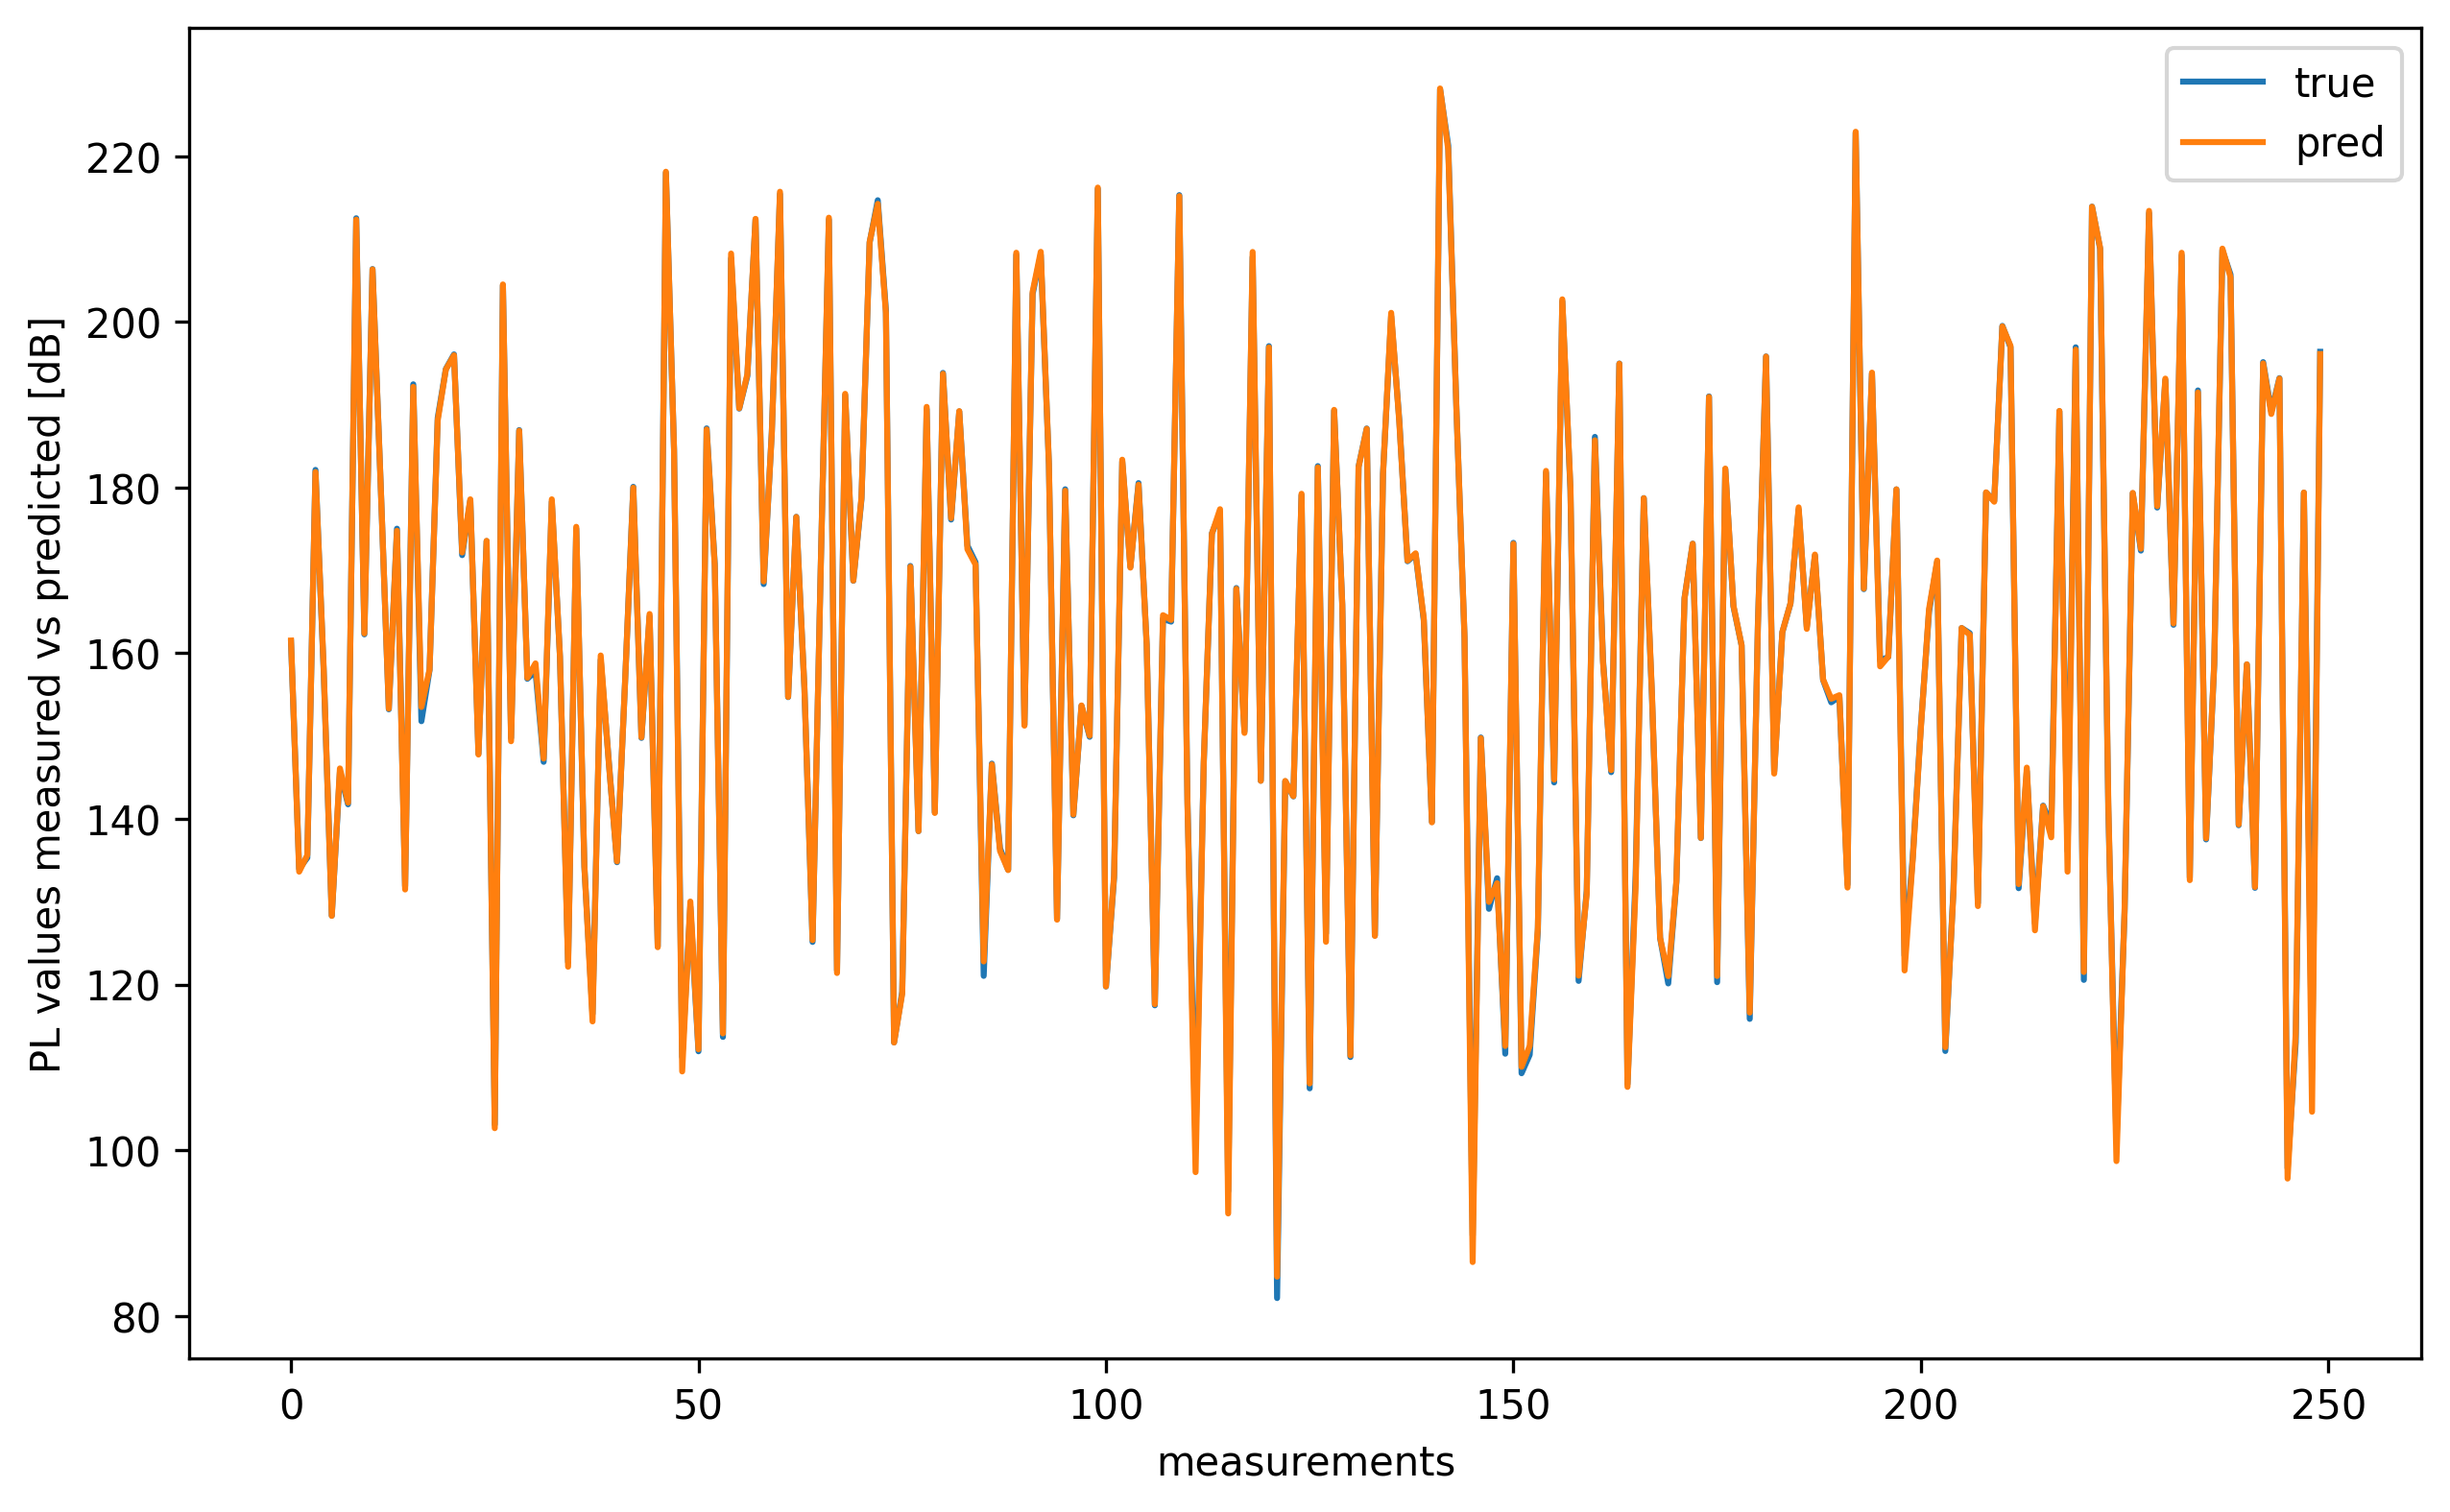

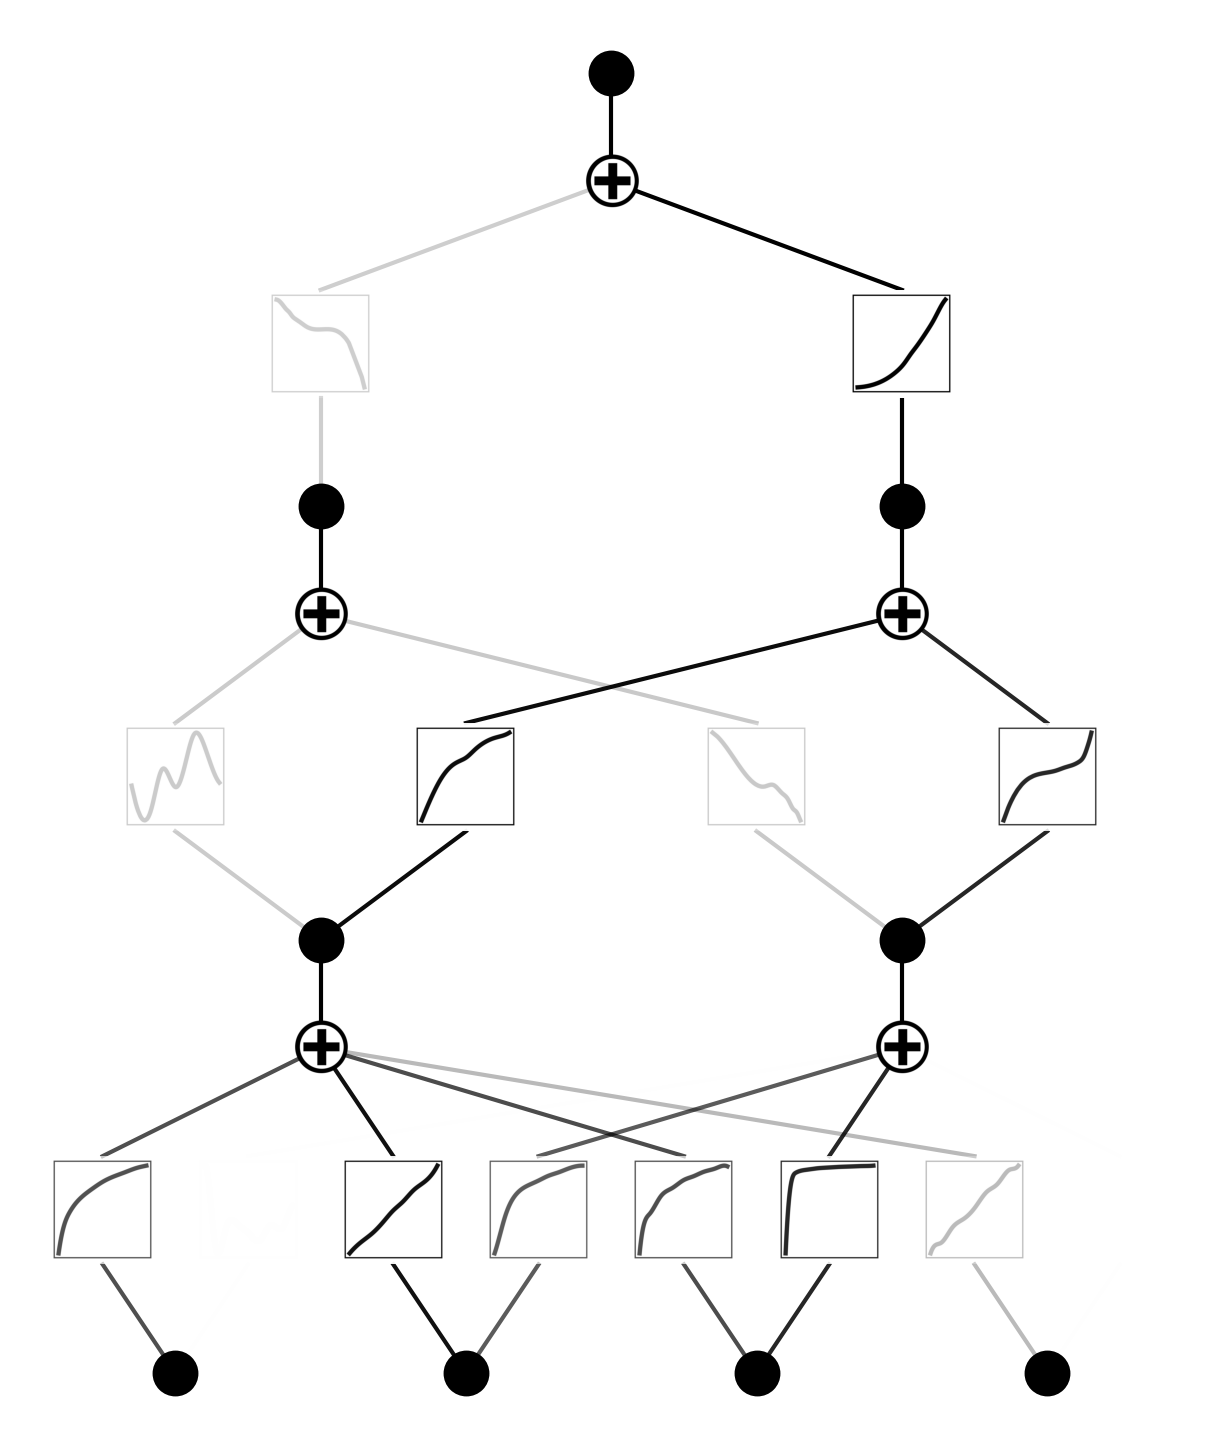

In [59]:

from kan import *
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

from scipy import constants

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['figure.dpi'] = 300

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


def eval_kan(model_kan, f, test_data):
    y_true = test_data['test_label']
    with torch.no_grad():
        y_pred = model_kan(test_data['test_input'])
        
    y_true = y_true.detach().cpu().numpy().ravel()[:250]
    y_pred = y_pred.detach().cpu().numpy().ravel()[:250]
    time = range(len(y_true))

    # Plot the training and test losses.
    plt.plot(time, y_true)
    plt.plot(time, y_pred)
    if f is not nan:
        y_symbolic = f(test_data['test_input'])[:250]
        plt.plot(time, y_symbolic)
        plt.legend(['true', 'pred', 'symbolic'])
    else:
        plt.legend(['true', 'pred'])
    plt.ylabel('PL values measured vs predicted [dB]')
    plt.xlabel('measurements')


    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)

    mape_frac = mean_absolute_percentage_error(y_true, y_pred)
    mape = mape_frac * 100
    
    # Print results
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"MAPE: {mape:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")

    return mse, rmse, mae, mape, r2

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_gids_steps_lambda_loss(gids_size, steps, lam, metric, metric_name):
    """
    Plots a 3D scatter of gids_size vs steps vs train_loss, 
    with point color representing lambda.
    
    Parameters:
    - gids_size: array-like of shape (N,)
    - steps: array-like of shape (N,)
    - lam: array-like of shape (N,)
    - train_loss: array-like of shape (N,)
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(gids_size, steps, lam, c=metric)
    
    ax.set_xlabel('gids size')
    ax.set_ylabel('steps')
    ax.set_zlabel('lambda')
    
    plt.colorbar(sc, label=metric_name)
    plt.title('3D Scatter: gids size vs steps vs lambda (' + metric_name + ' as color)')
    plt.show()

# create dataset of 1000 samples
f = lambda x: 20 * torch.log10((4 * torch.pi * x[:,[0]]) / constants.c) + 10 * x[:,[1]] * torch.log10(x[:,[2]]) + x[:,[3]]
dataset = create_dataset(f, 
                        n_var=4, 
                        ranges=[(2000000000,73000000000), (2, 6), (1, 500), (4,12) ], 
                        train_num=1000,
                        device=device)

# x[:,[0]] dominates, so normalize the features
# 1. Get data
X_train = dataset['train_input'].cpu().numpy()
X_test  = dataset['test_input'].cpu().numpy()

# 2. Fit scaler on training data only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# 3. Convert back to torch tensors
dataset['train_input'] = torch.tensor(X_train_scaled, dtype=torch.float32)
dataset['test_input']  = torch.tensor(X_test_scaled, dtype=torch.float32)

dataset['train_input'].shape, dataset['train_label'].shape



model = KAN(width=[4,2,2,1], grid=8, k=3, seed=42, device=device)

# this is the learnt KAN model (splines + edge weights)
model.fit(dataset, opt="LBFGS", steps=200, lamb=0.002, lamb_entropy=2.);

eval_kan(model, nan, dataset)
model.plot()

# this is the symbolic approximation of the learnt splines with interpretable mathematical functions
add_symbolic('log10', torch.log10)
model.auto_symbolic()

ex_round(model.symbolic_formula()[0][0], 3)


MAE: 9.3262
MSE: 150.6867
MAPE: 5.6476
R²: 0.8430
RMSE: 12.2754


(150.68666076660156,
 np.float64(12.275449513830504),
 9.326228141784668,
 5.647598952054977,
 0.8429712057113647)

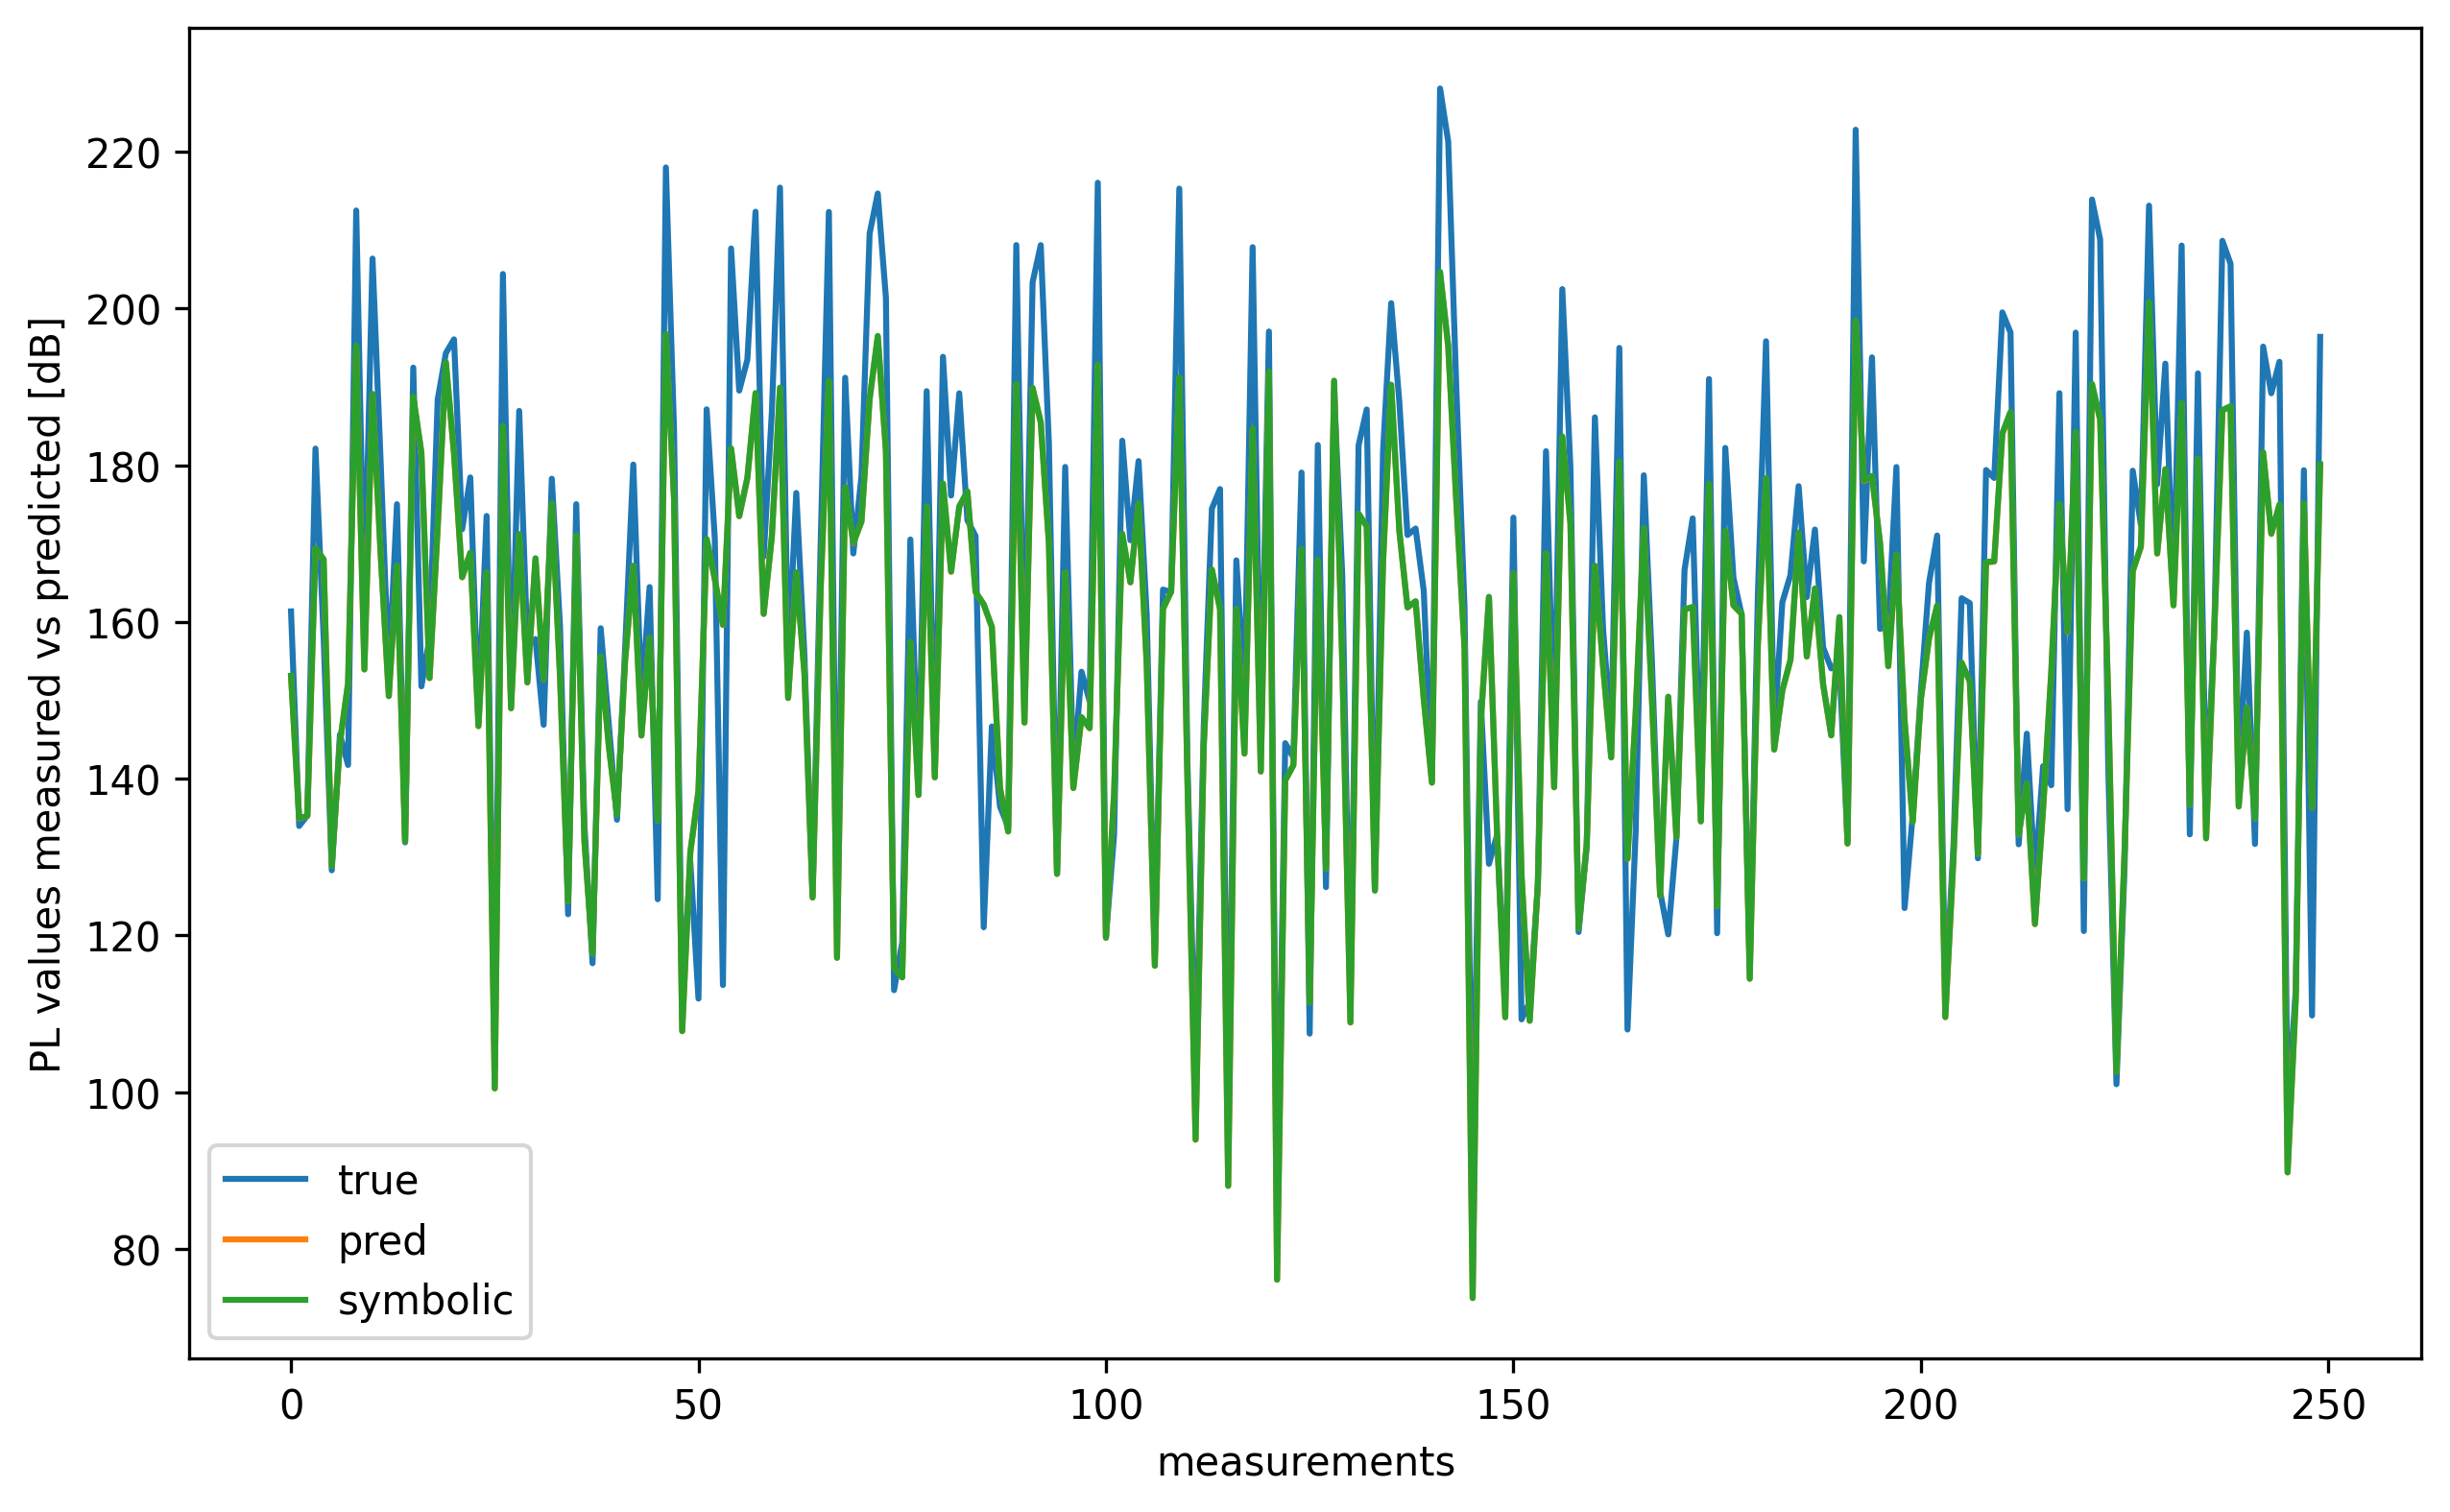

In [60]:

f = lambda x: 293.96 - 282.958 * torch.log10(0.94 * torch.log10(0.46 - 0.299 * torch.log10(5.012 * x[:,[1]] + 9.22)) - 3.669 * torch.log10(0.85 * x[:,[1]] + 0.145 * x[:,[3]] + 1.245 * torch.log10(4.127 * x[:,[0]] + 7.469) + 1.319 * torch.log10(5.345 * x[:,[2]] + 9.694) + 1.818) + 5.974)
eval_kan(model, f, dataset)


checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 100, 0.02


| train_loss: 1.80e+00 | test_loss: 2.07e+00 | reg: 6.98e+01 | : 100%|█| 100/100 [00:24<00:00,  4.04


saving model version 0.1
MAE: 1.1912
MSE: 4.1072
MAPE: 0.8799
R²: 0.9957
RMSE: 2.0266
[np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 100, 0.002


| train_loss: 8.09e-01 | test_loss: 8.54e-01 | reg: 4.24e+01 | : 100%|█| 100/100 [00:20<00:00,  4.91


saving model version 0.1
MAE: 0.5233
MSE: 0.6941
MAPE: 0.3712
R²: 0.9993
RMSE: 0.8331
[np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 100, 0.0002


| train_loss: 9.67e-01 | test_loss: 1.05e+00 | reg: 4.17e+01 | : 100%|█| 100/100 [00:20<00:00,  4.92


saving model version 0.1
MAE: 0.6484
MSE: 0.9652
MAPE: 0.4386
R²: 0.9990
RMSE: 0.9825
[np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 100, 2e-05


| train_loss: 1.17e+00 | test_loss: 1.40e+00 | reg: 4.98e+01 | : 100%|█| 100/100 [00:19<00:00,  5.05


saving model version 0.1
MAE: 0.8145
MSE: 2.0582
MAPE: 0.6233
R²: 0.9979
RMSE: 1.4346
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 200, 0.02


| train_loss: 1.34e+00 | test_loss: 1.44e+00 | reg: 5.23e+01 | : 100%|█| 200/200 [00:44<00:00,  4.46


saving model version 0.1
MAE: 0.8298
MSE: 2.3039
MAPE: 0.6227
R²: 0.9976
RMSE: 1.5179
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 200, 0.002


| train_loss: 6.91e-01 | test_loss: 7.96e-01 | reg: 4.52e+01 | : 100%|█| 200/200 [00:43<00:00,  4.58


saving model version 0.1
MAE: 0.4471
MSE: 0.7034
MAPE: 0.3315
R²: 0.9993
RMSE: 0.8387
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 200, 0.0002


| train_loss: 9.13e-01 | test_loss: 9.89e-01 | reg: 4.82e+01 | : 100%|█| 200/200 [00:43<00:00,  4.63


saving model version 0.1
MAE: 0.6125
MSE: 0.8369
MAPE: 0.4084
R²: 0.9991
RMSE: 0.9148
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 200, 2e-05


| train_loss: 1.04e+00 | test_loss: 1.33e+00 | reg: 4.94e+01 | : 100%|█| 200/200 [00:42<00:00,  4.66


saving model version 0.1
MAE: 0.7006
MSE: 1.8815
MAPE: 0.5523
R²: 0.9980
RMSE: 1.3717
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 300, 0.02


| train_loss: 1.13e+00 | test_loss: 1.26e+00 | reg: 4.83e+01 | : 100%|█| 300/300 [01:12<00:00,  4.12


saving model version 0.1
MAE: 0.7128
MSE: 1.9547
MAPE: 0.5608
R²: 0.9980
RMSE: 1.3981
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 300, 0.002


| train_loss: 6.91e-01 | test_loss: 7.96e-01 | reg: 4.52e+01 | : 100%|█| 300/300 [00:45<00:00,  6.54


saving model version 0.1
MAE: 0.4471
MSE: 0.7034
MAPE: 0.3315
R²: 0.9993
RMSE: 0.8387
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 300, 0.0002


| train_loss: 8.68e-01 | test_loss: 9.39e-01 | reg: 6.53e+01 | : 100%|█| 300/300 [01:00<00:00,  4.92


saving model version 0.1
MAE: 0.5893
MSE: 0.7850
MAPE: 0.3975
R²: 0.9992
RMSE: 0.8860
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 300, 2e-05


| train_loss: 1.01e+00 | test_loss: 1.34e+00 | reg: 4.90e+01 | : 100%|█| 300/300 [00:55<00:00,  5.38


saving model version 0.1
MAE: 0.6738
MSE: 1.8534
MAPE: 0.5349
R²: 0.9981
RMSE: 1.3614
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 100, 0.02


| train_loss: 1.97e+00 | test_loss: 2.41e+00 | reg: 2.30e+02 | : 100%|█| 100/100 [00:24<00:00,  4.10


saving model version 0.1
MAE: 1.3349
MSE: 4.0284
MAPE: 0.9533
R²: 0.9958
RMSE: 2.0071
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 100, 0.002


| train_loss: 7.30e-01 | test_loss: 1.09e+00 | reg: 1.80e+02 | : 100%|█| 100/100 [00:22<00:00,  4.54


saving model version 0.1
MAE: 0.4430
MSE: 0.6925
MAPE: 0.3260
R²: 0.9993
RMSE: 0.8322
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 100, 0.0002


| train_loss: 1.33e+01 | test_loss: 1.72e+01 | reg: 1.65e+02 | : 100%|█| 100/100 [00:25<00:00,  3.92


saving model version 0.1
MAE: 10.5449
MSE: 279.7821
MAPE: 7.3614
R²: 0.7084
RMSE: 16.7267
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 100, 2e-05


| train_loss: 4.17e+00 | test_loss: 6.03e+00 | reg: 2.04e+02 | : 100%|█| 100/100 [00:25<00:00,  3.86


saving model version 0.1
MAE: 3.4029
MSE: 37.5716
MAPE: 2.3423
R²: 0.9608
RMSE: 6.1296
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 200, 0.02


| train_loss: 1.83e+00 | test_loss: 2.20e+00 | reg: 2.29e+02 | : 100%|█| 200/200 [00:51<00:00,  3.87


saving model version 0.1
MAE: 1.3216
MSE: 3.8044
MAPE: 0.9405
R²: 0.9960
RMSE: 1.9505
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 200, 0.002


| train_loss: 6.15e-01 | test_loss: 9.16e-01 | reg: 1.78e+02 | : 100%|█| 200/200 [00:48<00:00,  4.17


saving model version 0.1
MAE: 0.3549
MSE: 0.4781
MAPE: 0.2749
R²: 0.9995
RMSE: 0.6915
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 200, 0.0002


| train_loss: 1.07e+01 | test_loss: 1.69e+01 | reg: 1.80e+02 | : 100%|█| 200/200 [00:49<00:00,  4.05


saving model version 0.1
MAE: 8.5140
MSE: 224.6352
MAPE: 5.8444
R²: 0.7659
RMSE: 14.9878
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 200, 2e-05


| train_loss: 3.38e+00 | test_loss: 5.70e+00 | reg: 2.14e+02 | : 100%|█| 200/200 [00:55<00:00,  3.61


saving model version 0.1
MAE: 2.9021
MSE: 30.5671
MAPE: 2.0156
R²: 0.9681
RMSE: 5.5288
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 300, 0.02


| train_loss: 1.76e+00 | test_loss: 2.18e+00 | reg: 2.26e+02 | : 100%|█| 300/300 [01:17<00:00,  3.86


saving model version 0.1
MAE: 1.2510
MSE: 3.5023
MAPE: 0.8941
R²: 0.9964
RMSE: 1.8714
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 300, 0.002


| train_loss: 5.70e-01 | test_loss: 7.44e-01 | reg: 1.76e+02 | : 100%|█| 300/300 [01:07<00:00,  4.46


saving model version 0.1
MAE: 0.3067
MSE: 0.3786
MAPE: 0.2377
R²: 0.9996
RMSE: 0.6153
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 300, 0.0002


| train_loss: 9.24e+00 | test_loss: 1.61e+01 | reg: 1.84e+02 | : 100%|█| 300/300 [01:07<00:00,  4.45


saving model version 0.1
MAE: 7.9964
MSE: 219.8880
MAPE: 5.5376
R²: 0.7709
RMSE: 14.8286
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 300, 2e-05


| train_loss: 2.94e+00 | test_loss: 5.69e+00 | reg: 2.12e+02 | : 100%|█| 300/300 [01:13<00:00,  4.07


saving model version 0.1
MAE: 2.7705
MSE: 32.6298
MAPE: 1.9893
R²: 0.9660
RMSE: 5.7123
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 100, 0.02


| train_loss: 6.06e+00 | test_loss: 9.56e+00 | reg: 1.94e+02 | : 100%|█| 100/100 [00:24<00:00,  4.05


saving model version 0.1
MAE: 4.2416
MSE: 106.5103
MAPE: 3.4417
R²: 0.8890
RMSE: 10.3204
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 100, 0.002


| train_loss: 2.99e+00 | test_loss: 6.11e+00 | reg: 2.98e+02 | : 100%|█| 100/100 [00:25<00:00,  3.98


saving model version 0.1
MAE: 2.5619
MSE: 17.4400
MAPE: 1.8498
R²: 0.9818
RMSE: 4.1761
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 100, 0.0002


| train_loss: 7.68e+00 | test_loss: 1.01e+01 | reg: 1.83e+02 | : 100%|█| 100/100 [00:24<00:00,  4.13


saving model version 0.1
MAE: 6.2147
MSE: 86.5259
MAPE: 4.4102
R²: 0.9098
RMSE: 9.3019
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 100, 2e-05


| train_loss: 6.92e+00 | test_loss: 1.13e+01 | reg: 1.43e+02 | : 100%|█| 100/100 [00:25<00:00,  3.85


saving model version 0.1
MAE: 5.9071
MSE: 91.7714
MAPE: 4.2383
R²: 0.9044
RMSE: 9.5797
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 200, 0.02


| train_loss: 5.28e+00 | test_loss: 9.05e+00 | reg: 1.88e+02 | : 100%|█| 200/200 [00:51<00:00,  3.90


saving model version 0.1
MAE: 3.9835
MSE: 99.1880
MAPE: 3.2427
R²: 0.8966
RMSE: 9.9593
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 200, 0.002


| train_loss: 2.16e+00 | test_loss: 4.93e+00 | reg: 3.32e+02 | : 100%|█| 200/200 [00:48<00:00,  4.15


saving model version 0.1
MAE: 2.0899
MSE: 12.2373
MAPE: 1.5750
R²: 0.9872
RMSE: 3.4982
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 200, 0.0002


| train_loss: 6.68e+00 | test_loss: 9.82e+00 | reg: 1.88e+02 | : 100%|█| 200/200 [00:42<00:00,  4.66


saving model version 0.1
MAE: 5.5930
MSE: 85.4344
MAPE: 4.0206
R²: 0.9110
RMSE: 9.2431
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 200, 2e-05


| train_loss: 5.63e+00 | test_loss: 1.32e+01 | reg: 1.44e+02 | : 100%|█| 200/200 [00:42<00:00,  4.68


saving model version 0.1
MAE: 5.3781
MSE: 75.7768
MAPE: 3.9246
R²: 0.9210
RMSE: 8.7050
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 300, 0.02


| train_loss: 4.79e+00 | test_loss: 9.28e+00 | reg: 1.96e+02 | : 100%|█| 300/300 [01:06<00:00,  4.53


saving model version 0.1
MAE: 4.0720
MSE: 100.2427
MAPE: 3.3019
R²: 0.8955
RMSE: 10.0121
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 300, 0.002


| train_loss: 1.99e+00 | test_loss: 5.35e+00 | reg: 3.26e+02 | : 100%|█| 300/300 [01:03<00:00,  4.72


saving model version 0.1
MAE: 1.9416
MSE: 11.2815
MAPE: 1.4924
R²: 0.9882
RMSE: 3.3588
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 300, 0.0002


| train_loss: 6.04e+00 | test_loss: 9.29e+00 | reg: 1.80e+02 | : 100%|█| 300/300 [01:03<00:00,  4.71


saving model version 0.1
MAE: 5.3792
MSE: 87.3648
MAPE: 3.9751
R²: 0.9090
RMSE: 9.3469
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 300, 2e-05


| train_loss: 5.16e+00 | test_loss: 1.32e+01 | reg: 1.43e+02 | : 100%|█| 300/300 [01:01<00:00,  4.87


saving model version 0.1
MAE: 5.0385
MSE: 64.6286
MAPE: 3.6915
R²: 0.9327
RMSE: 8.0392
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 15, steps 100, 0.02


| train_loss: 3.37e+00 | test_loss: 3.67e+00 | reg: 1.59e+02 | : 100%|█| 100/100 [01:16<00:00,  1.30


saving model version 0.1
MAE: 2.1369
MSE: 10.4373
MAPE: 1.5223
R²: 0.9891
RMSE: 3.2307
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 15, steps 100, 0.002


| train_loss: 3.71e+00 | test_loss: 4.55e+00 | reg: 1.29e+02 | : 100%|█| 100/100 [00:54<00:00,  1.83


saving model version 0.1
MAE: 2.5431
MSE: 16.3812
MAPE: 1.8796
R²: 0.9829
RMSE: 4.0474
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 15, steps 100, 0.0002


| train_loss: 4.85e+00 | test_loss: 6.24e+00 | reg: 1.45e+02 | : 100%|█| 100/100 [01:12<00:00,  1.38


saving model version 0.1
MAE: 3.3163
MSE: 67.4271
MAPE: 2.6340
R²: 0.9297
RMSE: 8.2114
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 15, steps 100, 2e-05


| train_loss: 3.60e+00 | test_loss: 3.73e+00 | reg: 1.88e+02 | : 100%|█| 100/100 [00:57<00:00,  1.75


saving model version 0.1
MAE: 2.3915
MSE: 10.8802
MAPE: 1.6741
R²: 0.9887
RMSE: 3.2985
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 15, steps 200, 0.02


| train_loss: 2.80e+00 | test_loss: 2.97e+00 | reg: 1.55e+02 | : 100%|█| 200/200 [02:16<00:00,  1.47


saving model version 0.1
MAE: 1.8701
MSE: 8.1367
MAPE: 1.3877
R²: 0.9915
RMSE: 2.8525
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 15, steps 200, 0.002


| train_loss: 2.88e+00 | test_loss: 3.07e+00 | reg: 1.12e+02 | : 100%|█| 200/200 [02:19<00:00,  1.43


saving model version 0.1
MAE: 1.7859
MSE: 8.6684
MAPE: 1.3295
R²: 0.9910
RMSE: 2.9442
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 15, steps 200, 0.0002


| train_loss: 3.47e+00 | test_loss: 5.63e+00 | reg: 1.42e+02 | : 100%|█| 200/200 [02:26<00:00,  1.36


saving model version 0.1
MAE: 2.5914
MSE: 31.7391
MAPE: 2.0053
R²: 0.9669
RMSE: 5.6337
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 15, steps 200, 2e-05


| train_loss: 3.05e+00 | test_loss: 3.18e+00 | reg: 1.84e+02 | : 100%|█| 200/200 [01:52<00:00,  1.78


saving model version 0.1
MAE: 1.8258
MSE: 7.9984
MAPE: 1.3114
R²: 0.9917
RMSE: 2.8281
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 15,

| train_loss: 2.72e+00 | test_loss: 2.98e+00 | reg: 1.54e+02 | : 100%|█| 300/300 [02:40<00:00,  1.87


saving model version 0.1
MAE: 1.8921
MSE: 8.0093
MAPE: 1.3881
R²: 0.9917
RMSE: 2.8301
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 

| train_loss: 2.48e+00 | test_loss: 2.88e+00 | reg: 1.03e+02 | : 100%|█| 300/300 [03:12<00:00,  1.56


saving model version 0.1
MAE: 1.8586
MSE: 7.4560
MAPE: 1.3382
R²: 0.9922
RMSE: 2.7306
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
sa

| train_loss: 3.07e+00 | test_loss: 5.32e+00 | reg: 1.40e+02 | : 100%|█| 300/300 [02:15<00:00,  2.21


saving model version 0.1
MAE: 2.2697
MSE: 13.0909
MAPE: 1.6780
R²: 0.9864
RMSE: 3.6181
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint director

| train_loss: 3.02e+00 | test_loss: 3.17e+00 | reg: 1.85e+02 | : 100%|█| 300/300 [01:10<00:00,  4.23


saving model version 0.1
MAE: 1.8495
MSE: 8.1419
MAPE: 1.3297
R²: 0.9915
RMSE: 2.8534
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
c

| train_loss: 1.29e+01 | test_loss: 2.47e+01 | reg: 7.38e+01 | : 100%|█| 100/100 [00:25<00:00,  3.88


saving model version 0.1
MAE: 14.0997
MSE: 446.8879
MAPE: 9.4994
R²: 0.5343
RMSE: 21.1397
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05

| train_loss: 3.64e+01 | test_loss: 1.09e+02 | reg: 6.08e+01 | : 100%|█| 100/100 [00:25<00:00,  3.86


saving model version 0.1
MAE: 36.5050
MSE: 2674.4910
MAPE: 23.2080
R²: -1.7871
RMSE: 51.7155
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e

| train_loss: 1.50e+01 | test_loss: 2.39e+01 | reg: 6.79e+01 | : 100%|█| 100/100 [00:27<00:00,  3.70


saving model version 0.1
MAE: 16.5169
MSE: 458.5841
MAPE: 10.8786
R²: 0.5221
RMSE: 21.4146
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-0

| train_loss: 1.38e+01 | test_loss: 2.82e+01 | reg: 9.91e+01 | : 100%|█| 100/100 [00:41<00:00,  2.41


saving model version 0.1
MAE: 18.1419
MSE: 776.3533
MAPE: 12.3883
R²: 0.1910
RMSE: 27.8631
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-0

| train_loss: 1.08e+01 | test_loss: 2.20e+01 | reg: 7.53e+01 | : 100%|█| 200/200 [01:30<00:00,  2.21


saving model version 0.1
MAE: 13.9975
MSE: 501.8449
MAPE: 9.3637
R²: 0.4770
RMSE: 22.4019
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05

| train_loss: 2.54e+01 | test_loss: 1.85e+02 | reg: 5.76e+01 | : 100%|█| 200/200 [01:07<00:00,  2.97


saving model version 0.1
MAE: 49.3006
MSE: 68235.4609
MAPE: 32.1508
R²: -70.1074
RMSE: 261.2192
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64

| train_loss: 1.32e+01 | test_loss: 2.83e+01 | reg: 6.77e+01 | : 100%|█| 200/200 [01:23<00:00,  2.40


saving model version 0.1
MAE: 18.0548
MSE: 671.1909
MAPE: 11.9499
R²: 0.3006
RMSE: 25.9074
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-0

| train_loss: 1.18e+01 | test_loss: 2.51e+01 | reg: 9.15e+01 | : 100%|█| 200/200 [01:09<00:00,  2.89


saving model version 0.1
MAE: 19.0024
MSE: 753.9941
MAPE: 13.1438
R²: 0.2143
RMSE: 27.4590
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-0

| train_loss: 9.85e+00 | test_loss: 2.43e+01 | reg: 7.59e+01 | : 100%|█| 300/300 [01:19<00:00,  3.78


saving model version 0.1
MAE: 13.8480
MSE: 503.1558
MAPE: 9.2613
R²: 0.4757
RMSE: 22.4311
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05

| train_loss: 2.27e+01 | test_loss: 1.57e+02 | reg: 5.51e+01 | : 100%|█| 300/300 [01:53<00:00,  2.65


saving model version 0.1
MAE: 41.4535
MSE: 31383.8086
MAPE: 26.7543
R²: -31.7047
RMSE: 177.1548
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64

| train_loss: 1.27e+01 | test_loss: 3.09e+01 | reg: 6.72e+01 | : 100%|█| 300/300 [01:40<00:00,  2.97


saving model version 0.1
MAE: 18.7268
MSE: 838.0336
MAPE: 12.4302
R²: 0.1267
RMSE: 28.9488
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-0

| train_loss: 1.13e+01 | test_loss: 2.56e+01 | reg: 8.96e+01 | : 100%|█| 300/300 [01:39<00:00,  3.03


saving model version 0.1
MAE: 18.8630
MSE: 726.9653
MAPE: 13.0407
R²: 0.2424
RMSE: 26.9623
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-0

| train_loss: 1.80e+00 | test_loss: 3.82e+00 | reg: 5.40e+01 | : 100%|█| 100/100 [00:39<00:00,  2.54


saving model version 0.1
MAE: 2.5257
MSE: 21.4991
MAPE: 1.9002
R²: 0.9776
RMSE: 4.6367
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 100/100 [00:38<00:00,  2.58it/s]


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Grid size: 30, steps 100, 0.0002


| train_loss: 1.27e+01 | test_loss: 3.73e+01 | reg: 6.83e+01 | : 100%|█| 100/100 [00:28<00:00,  3.57


saving model version 0.1
MAE: 30.8225
MSE: 1592.1125
MAPE: 20.3165
R²: -0.6591
RMSE: 39.9013
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e

| train_loss: 3.29e+01 | test_loss: 4.12e+01 | reg: 7.10e+01 | : 100%|█| 100/100 [00:27<00:00,  3.61


saving model version 0.1
MAE: 32.0696
MSE: 2102.7063
MAPE: 21.2025
R²: -1.1912
RMSE: 45.8553
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e

| train_loss: 1.45e+00 | test_loss: 4.30e+00 | reg: 5.44e+01 | : 100%|█| 200/200 [01:24<00:00,  2.37


saving model version 0.1
MAE: 2.8959
MSE: 25.2546
MAPE: 2.1660
R²: 0.9737
RMSE: 5.0254
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 200/200 [01:26<00:00,  2.31it/s]


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Grid size: 30, steps 200, 0.0002


| train_loss: 1.21e+01 | test_loss: 3.83e+01 | reg: 6.87e+01 | : 100%|█| 200/200 [01:00<00:00,  3.29


saving model version 0.1
MAE: 32.1423
MSE: 1705.0165
MAPE: 21.1646
R²: -0.7768
RMSE: 41.2918
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e

| train_loss: 2.23e+01 | test_loss: 4.11e+01 | reg: 7.65e+01 | : 100%|█| 200/200 [01:26<00:00,  2.32


saving model version 0.1
MAE: 27.4647
MSE: 1532.3230
MAPE: 18.3997
R²: -0.5968
RMSE: 39.1449
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e

| train_loss: 1.39e+00 | test_loss: 4.44e+00 | reg: 5.44e+01 | : 100%|█| 300/300 [01:27<00:00,  3.43


saving model version 0.1
MAE: 2.9880
MSE: 26.4703
MAPE: 2.2429
R²: 0.9724
RMSE: 5.1449
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 300/300 [01:32<00:00,  3.23it/s]


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Grid size: 30, steps 300, 0.0002


| train_loss: 1.20e+01 | test_loss: 3.86e+01 | reg: 6.88e+01 | : 100%|█| 300/300 [01:20<00:00,  3.72


saving model version 0.1
MAE: 32.8560
MSE: 1830.5540
MAPE: 21.7264
R²: -0.9076
RMSE: 42.7850
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e

| train_loss: 1.93e+01 | test_loss: 3.93e+01 | reg: 7.81e+01 | : 100%|█| 300/300 [01:26<00:00,  3.48


saving model version 0.1
MAE: 26.4603
MSE: 1357.3845
MAPE: 17.8627
R²: -0.4145
RMSE: 36.8427
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e

| train_loss: 2.15e+01 | test_loss: 3.18e+01 | reg: 1.33e+02 | : 100%|█| 100/100 [00:32<00:00,  3.12


saving model version 0.1
MAE: 21.6086
MSE: 762.0723
MAPE: 14.5051
R²: 0.2059
RMSE: 27.6057
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-0

| train_loss: 2.42e+01 | test_loss: 3.34e+01 | reg: 1.38e+02 | : 100%|█| 100/100 [00:30<00:00,  3.26


saving model version 0.1
MAE: 26.1458
MSE: 1141.5970
MAPE: 17.1474
R²: -0.1896
RMSE: 33.7875
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e

| train_loss: 2.31e+01 | test_loss: 3.70e+01 | reg: 1.13e+02 | : 100%|█| 100/100 [00:30<00:00,  3.23


saving model version 0.1
MAE: 26.5754
MSE: 1337.5968
MAPE: 17.6654
R²: -0.3939
RMSE: 36.5732
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e

| train_loss: 2.13e+01 | test_loss: 3.07e+01 | reg: 1.79e+02 | : 100%|█| 100/100 [00:31<00:00,  3.16


saving model version 0.1
MAE: 23.1619
MSE: 916.4333
MAPE: 15.3572
R²: 0.0450
RMSE: 30.2726
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-0

| train_loss: 1.72e+01 | test_loss: 3.03e+01 | reg: 1.33e+02 | : 100%|█| 200/200 [01:02<00:00,  3.18


saving model version 0.1
MAE: 19.7552
MSE: 680.9156
MAPE: 13.3046
R²: 0.2904
RMSE: 26.0944
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-0

| train_loss: 2.10e+01 | test_loss: 3.37e+01 | reg: 1.35e+02 | : 100%|█| 200/200 [01:01<00:00,  3.28


saving model version 0.1
MAE: 26.6123
MSE: 1194.7521
MAPE: 17.4334
R²: -0.2450
RMSE: 34.5652
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e

| train_loss: 2.02e+01 | test_loss: 3.76e+01 | reg: 1.14e+02 | : 100%|█| 200/200 [01:01<00:00,  3.26


saving model version 0.1
MAE: 25.7812
MSE: 1374.0419
MAPE: 16.9940
R²: -0.4319
RMSE: 37.0681
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e

| train_loss: 1.87e+01 | test_loss: 3.04e+01 | reg: 1.90e+02 | : 100%|█| 200/200 [01:04<00:00,  3.09


saving model version 0.1
MAE: 22.0693
MSE: 800.9946
MAPE: 14.4306
R²: 0.1653
RMSE: 28.3018
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-0

| train_loss: 1.54e+01 | test_loss: 3.06e+01 | reg: 1.36e+02 | : 100%|█| 300/300 [02:08<00:00,  2.34


saving model version 0.1
MAE: 20.2042
MSE: 687.7795
MAPE: 13.4618
R²: 0.2833
RMSE: 26.2256
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-0

| train_loss: 1.91e+01 | test_loss: 3.33e+01 | reg: 1.41e+02 | : 100%|█| 300/300 [02:03<00:00,  2.43


saving model version 0.1
MAE: 25.3425
MSE: 1122.1100
MAPE: 16.6271
R²: -0.1693
RMSE: 33.4979
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e

| train_loss: 1.89e+01 | test_loss: 3.79e+01 | reg: 1.20e+02 | : 100%|█| 300/300 [02:09<00:00,  2.31


saving model version 0.1
MAE: 24.9690
MSE: 1269.3815
MAPE: 16.3838
R²: -0.3228
RMSE: 35.6284
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e

| train_loss: 1.74e+01 | test_loss: 3.05e+01 | reg: 1.98e+02 | : 100%|█| 300/300 [02:14<00:00,  2.23


saving model version 0.1
MAE: 21.8303
MSE: 821.3940
MAPE: 14.1183
R²: 0.1440
RMSE: 28.6600
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-0

| train_loss: 2.31e+01 | test_loss: 2.97e+01 | reg: 9.56e+01 | : 100%|█| 100/100 [00:42<00:00,  2.36


saving model version 0.1
MAE: 23.0087
MSE: 794.6816
MAPE: 15.5068
R²: 0.1719
RMSE: 28.1901
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-0

| train_loss: 1.95e+01 | test_loss: 2.39e+01 | reg: 1.63e+02 | : 100%|█| 100/100 [00:34<00:00,  2.94


saving model version 0.1
MAE: 19.5584
MSE: 617.7155
MAPE: 13.1018
R²: 0.3563
RMSE: 24.8539
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-0

| train_loss: 3.16e+01 | test_loss: 4.49e+01 | reg: 6.82e+01 | : 100%|█| 100/100 [00:47<00:00,  2.09


saving model version 0.1
MAE: 35.8469
MSE: 2020.1281
MAPE: 22.8860
R²: -1.1052
RMSE: 44.9458
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e

| train_loss: 1.55e+01 | test_loss: 3.70e+01 | reg: 6.69e+01 | : 100%|█| 100/100 [00:53<00:00,  1.86


saving model version 0.1
MAE: 27.2616
MSE: 1206.0317
MAPE: 17.6947
R²: -0.2568
RMSE: 34.7280
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e

| train_loss: 1.74e+01 | test_loss: 2.83e+01 | reg: 1.16e+02 | : 100%|█| 200/200 [01:31<00:00,  2.19


saving model version 0.1
MAE: 22.4404
MSE: 746.4664
MAPE: 15.0727
R²: 0.2221
RMSE: 27.3215
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-0

| train_loss: 1.73e+01 | test_loss: 2.31e+01 | reg: 1.77e+02 | : 100%|█| 200/200 [01:02<00:00,  3.18


saving model version 0.1
MAE: 18.4140
MSE: 563.2535
MAPE: 12.2869
R²: 0.4130
RMSE: 23.7330
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-0

| train_loss: 2.48e+01 | test_loss: 4.32e+01 | reg: 6.38e+01 | : 100%|█| 200/200 [00:59<00:00,  3.35


saving model version 0.1
MAE: 34.6932
MSE: 1862.8177
MAPE: 22.3919
R²: -0.9412
RMSE: 43.1604
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e

| train_loss: 1.38e+01 | test_loss: 3.91e+01 | reg: 6.71e+01 | : 100%|█| 200/200 [01:01<00:00,  3.26


saving model version 0.1
MAE: 29.9391
MSE: 1456.5690
MAPE: 19.3484
R²: -0.5179
RMSE: 38.1650
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e

| train_loss: 1.53e+01 | test_loss: 2.85e+01 | reg: 1.26e+02 | : 100%|█| 300/300 [01:39<00:00,  3.00


saving model version 0.1
MAE: 22.0726
MSE: 770.2573
MAPE: 14.8970
R²: 0.1973
RMSE: 27.7535
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-0

| train_loss: 1.55e+01 | test_loss: 2.27e+01 | reg: 1.88e+02 | : 100%|█| 300/300 [01:32<00:00,  3.26


saving model version 0.1
MAE: 17.5924
MSE: 529.0260
MAPE: 11.7734
R²: 0.4487
RMSE: 23.0006
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-0

| train_loss: 2.13e+01 | test_loss: 4.19e+01 | reg: 6.21e+01 | : 100%|█| 300/300 [01:14<00:00,  4.02


saving model version 0.1
MAE: 33.2872
MSE: 1767.2632
MAPE: 21.3611
R²: -0.8416
RMSE: 42.0388
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e

| train_loss: 1.31e+01 | test_loss: 4.14e+01 | reg: 6.70e+01 | : 100%|█| 300/300 [00:50<00:00,  5.93


saving model version 0.1
MAE: 33.1244
MSE: 1759.6250
MAPE: 21.4591
R²: -0.8337
RMSE: 41.9479
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e

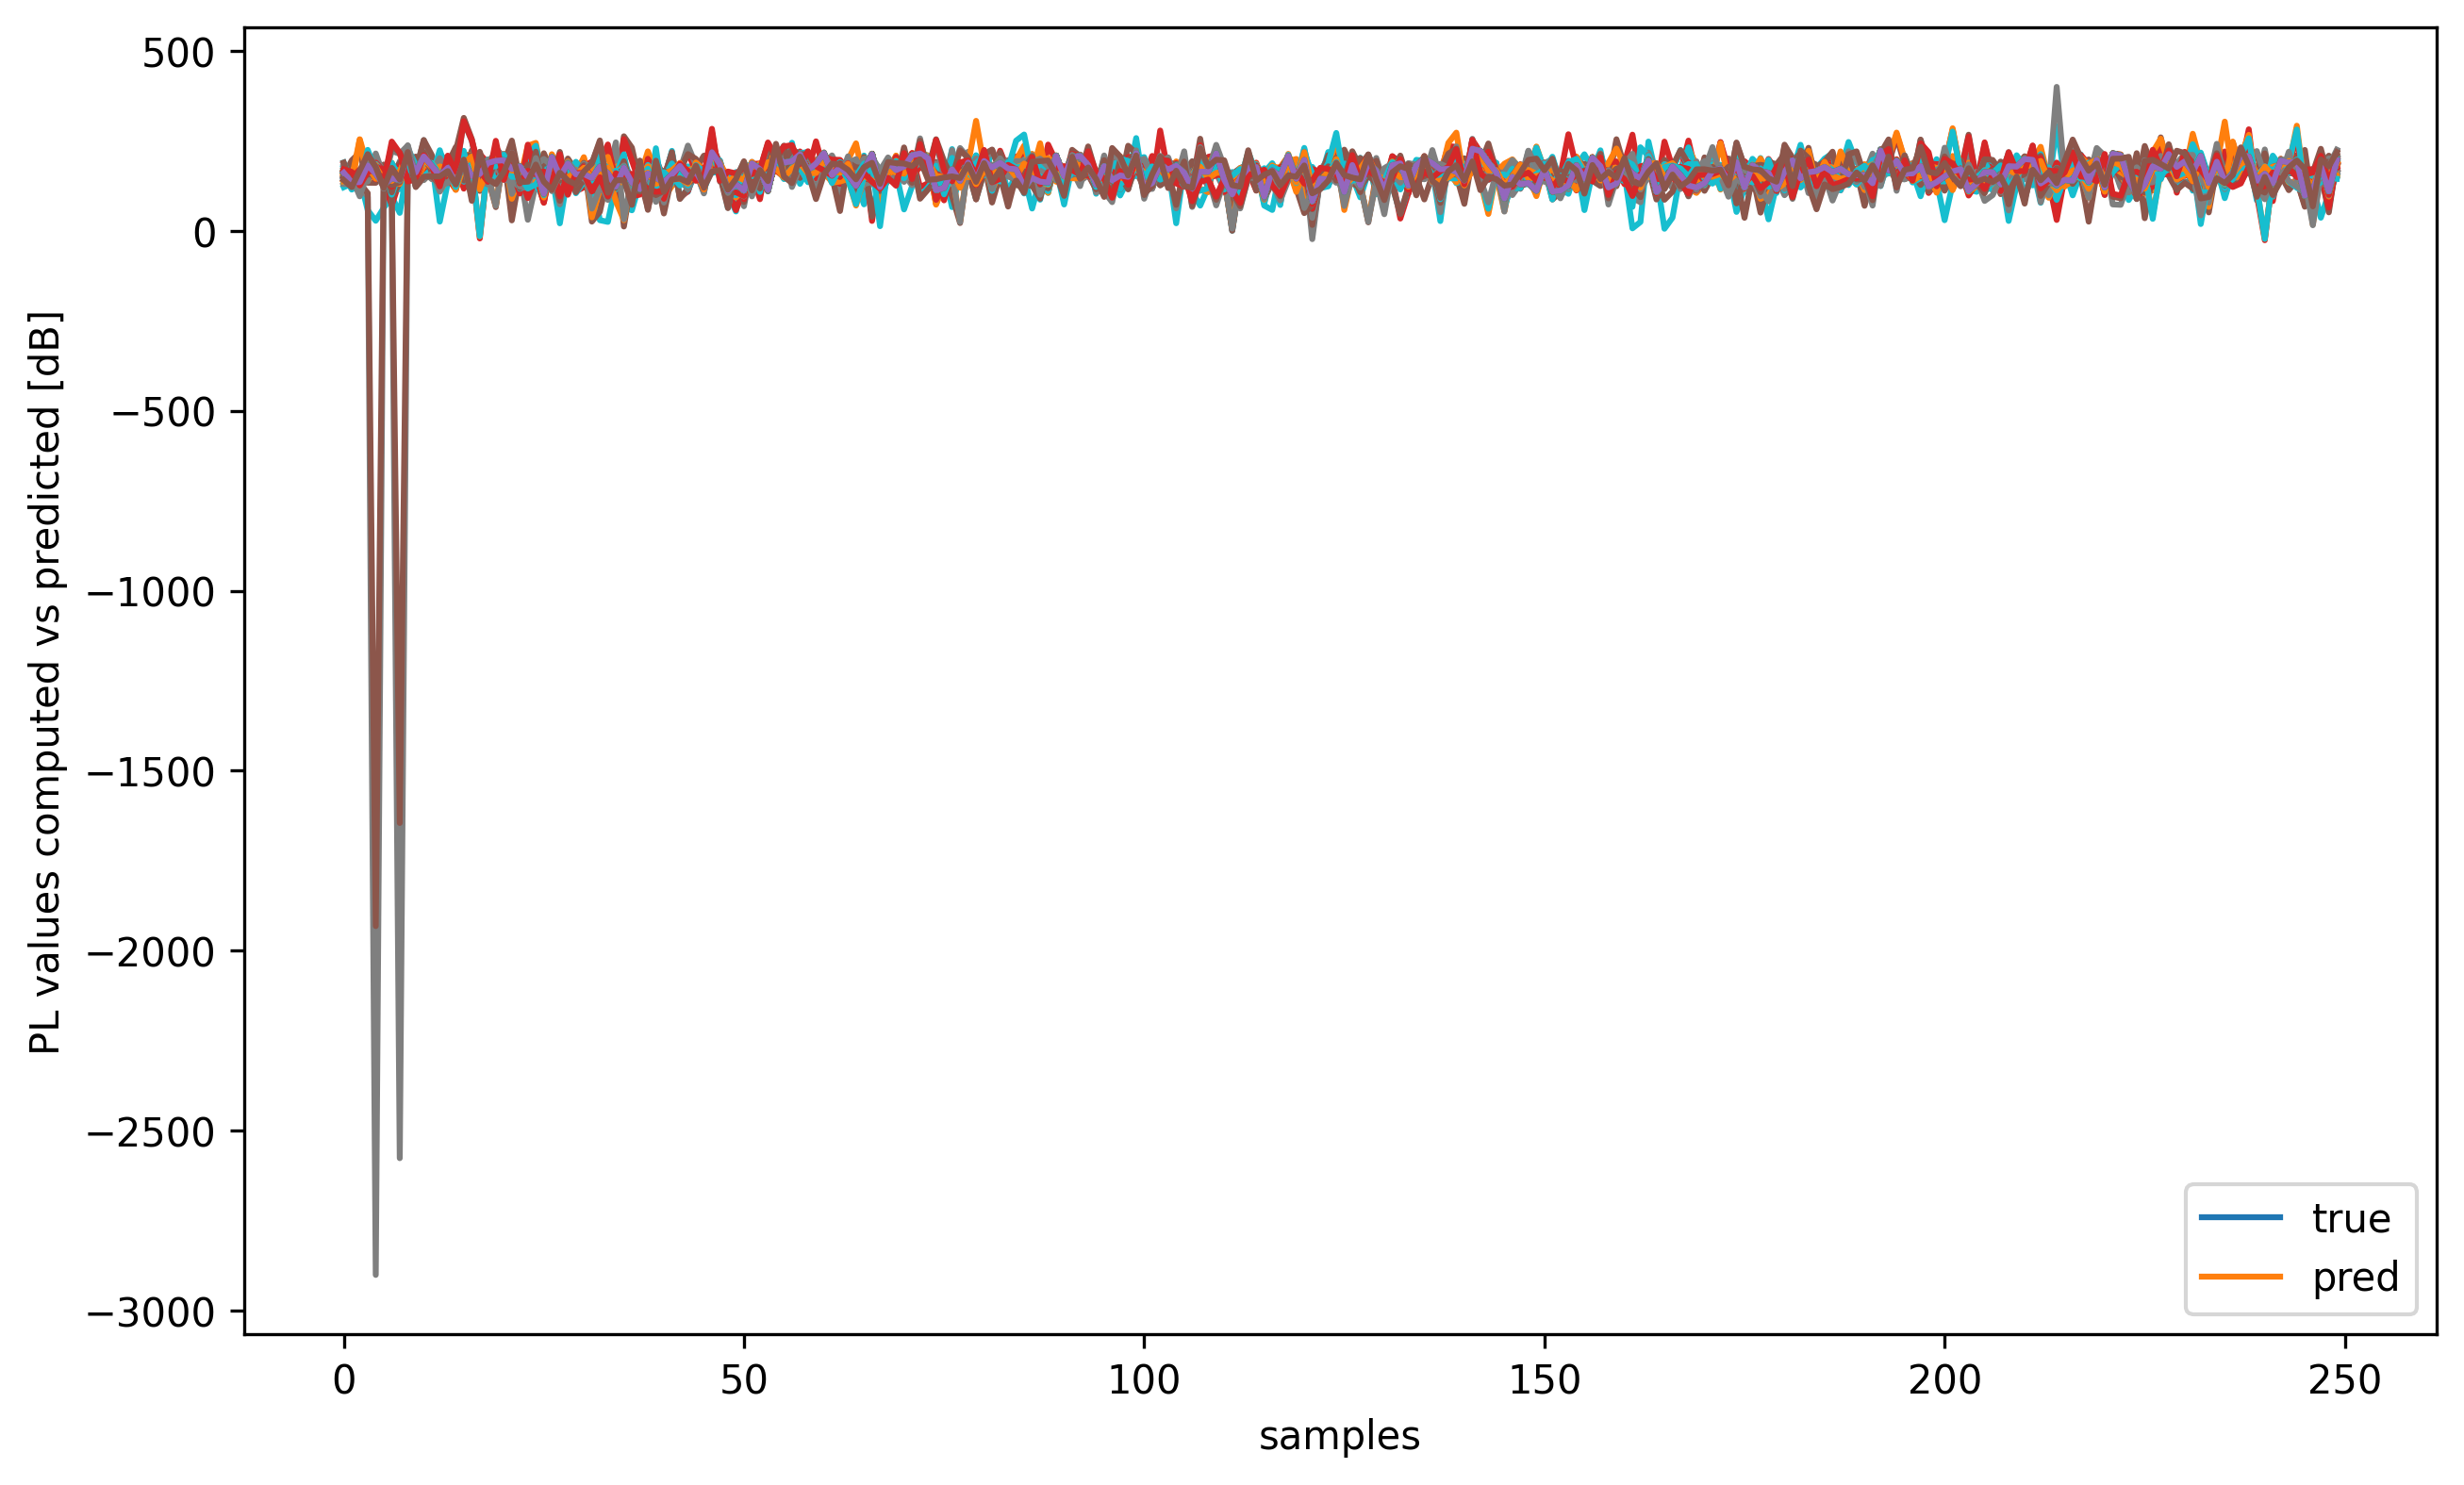

In [ ]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['figure.dpi'] = 300


# Store the training and test losses for each grid size for later plotting.
tr_losses = []
te_losses = []
plot_grids = []
plot_steps = []
plot_lambs = []
tr_maes = []
tr_mses = []
tr_mapes = []
tr_r2s = []

train_losses = []
test_losses = []

# Thee parameters for the KAN model.
grids = np.array([5, 8, 10, 15, 20, 30, 40, 50])
steps = np.array([100, 200, 300])
k = 3
lamb = np.array([0.02, 0.002, 0.0002, 0.00002])

for g in range(grids.shape[0]):
    for s in range(steps.shape[0]):
        for l in range(lamb.shape[0]):
            model= KAN(
                width=[4, 2, 2, 1], 
                grid=grids[g], 
                k=3, 
                seed=42, 
                device=device, 
            ) 
            
            print(f"Grid size: {grids[g]}, steps {steps[s]}, {lamb[l]}")
            results = model.fit(dataset, opt="LBFGS", lamb=lamb[l], steps=steps[s], lamb_entropy=2.)
            
            train_losses += results['train_loss']
            test_losses += results['test_loss']
            #print(np.array(train_losses).mean())

            if not np.isnan(results['train_loss']).any():
                tr_mse, tr_rmse, tr_mae, tr_mape, tr_r2 = eval_kan(model, nan, dataset);
                #te_mse, te_rmse, te_mae, te_mape, te_r2 = eval_kan(model, validation_data);

                plot_grids.append(grids[g])
                plot_steps.append(steps[s])
                plot_lambs.append(lamb[l])
                print(plot_lambs)
                
                tr_losses.append(np.array(train_losses).mean())
                te_losses.append(np.array(test_losses).mean())
                tr_maes.append(tr_mae)
                tr_mses.append(tr_mse)
                tr_mapes.append(tr_mape)
                tr_r2s.append(tr_r2)


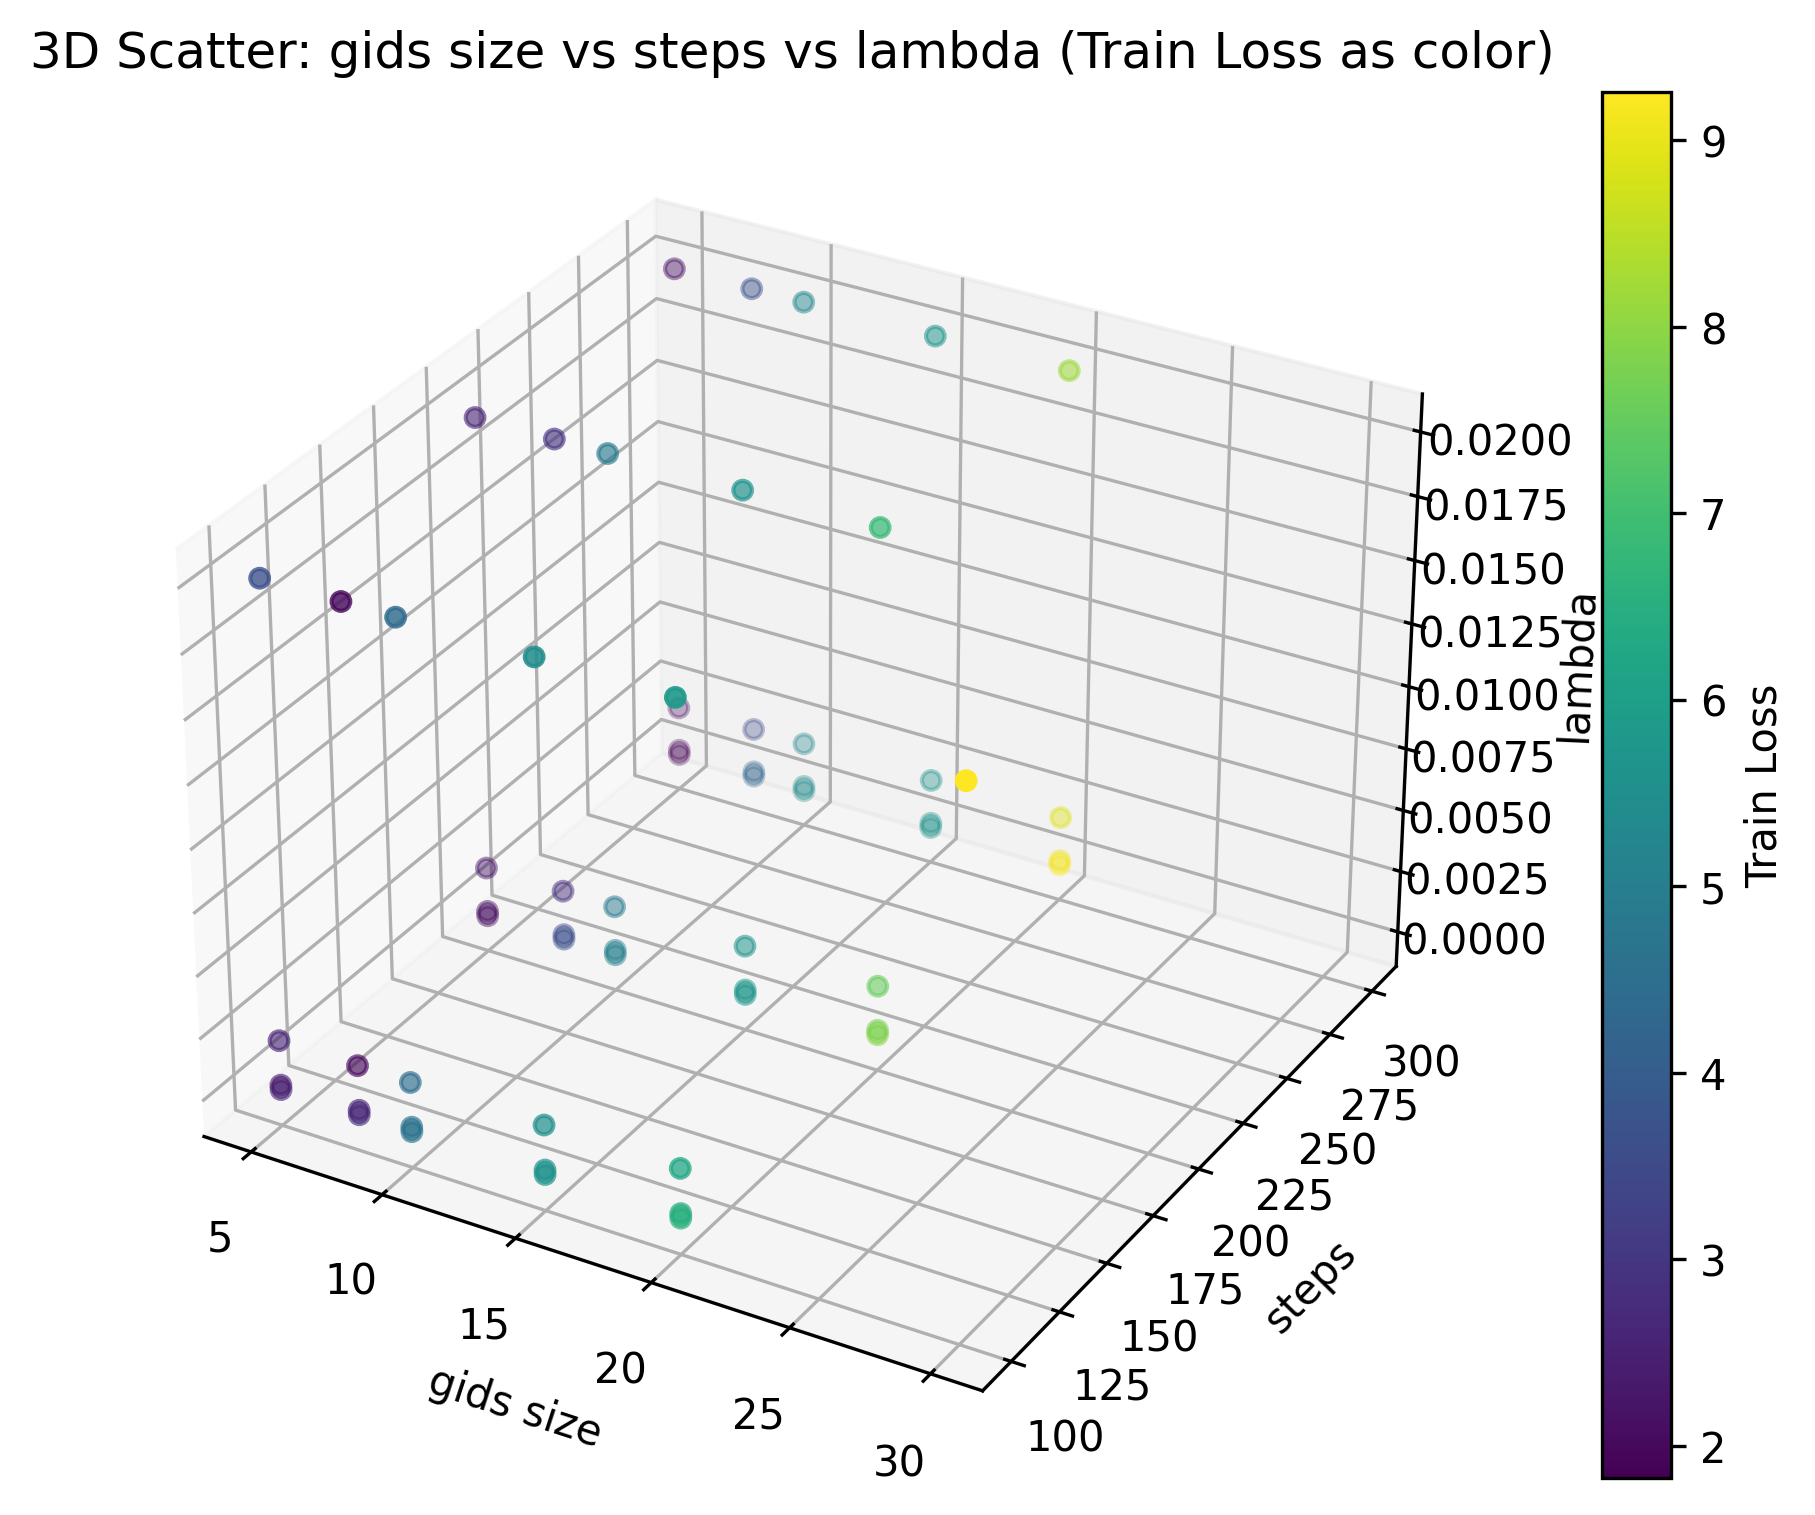

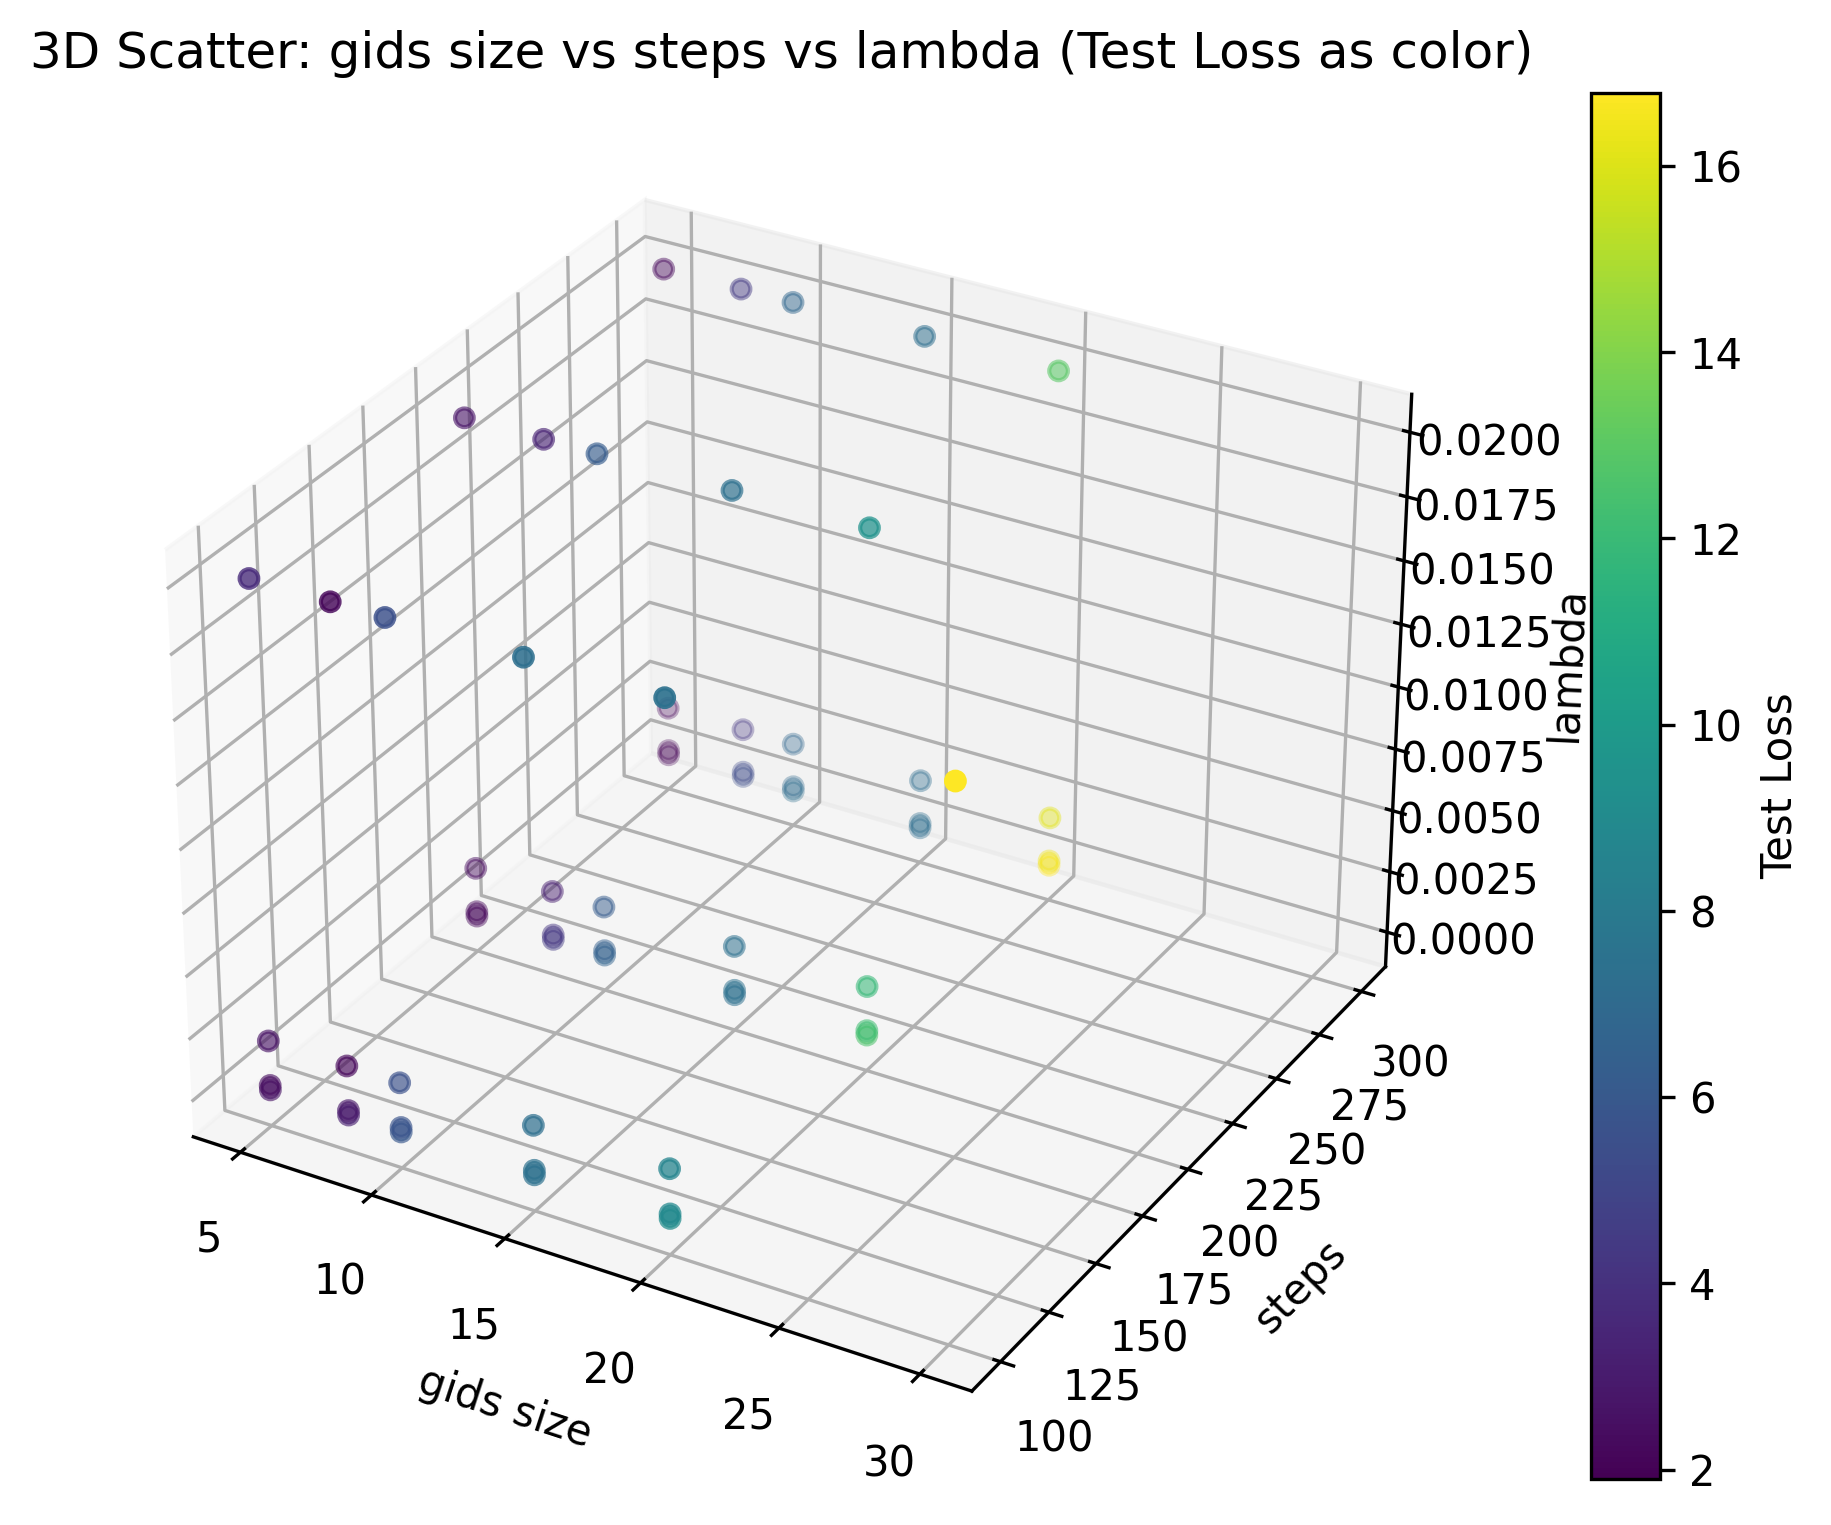

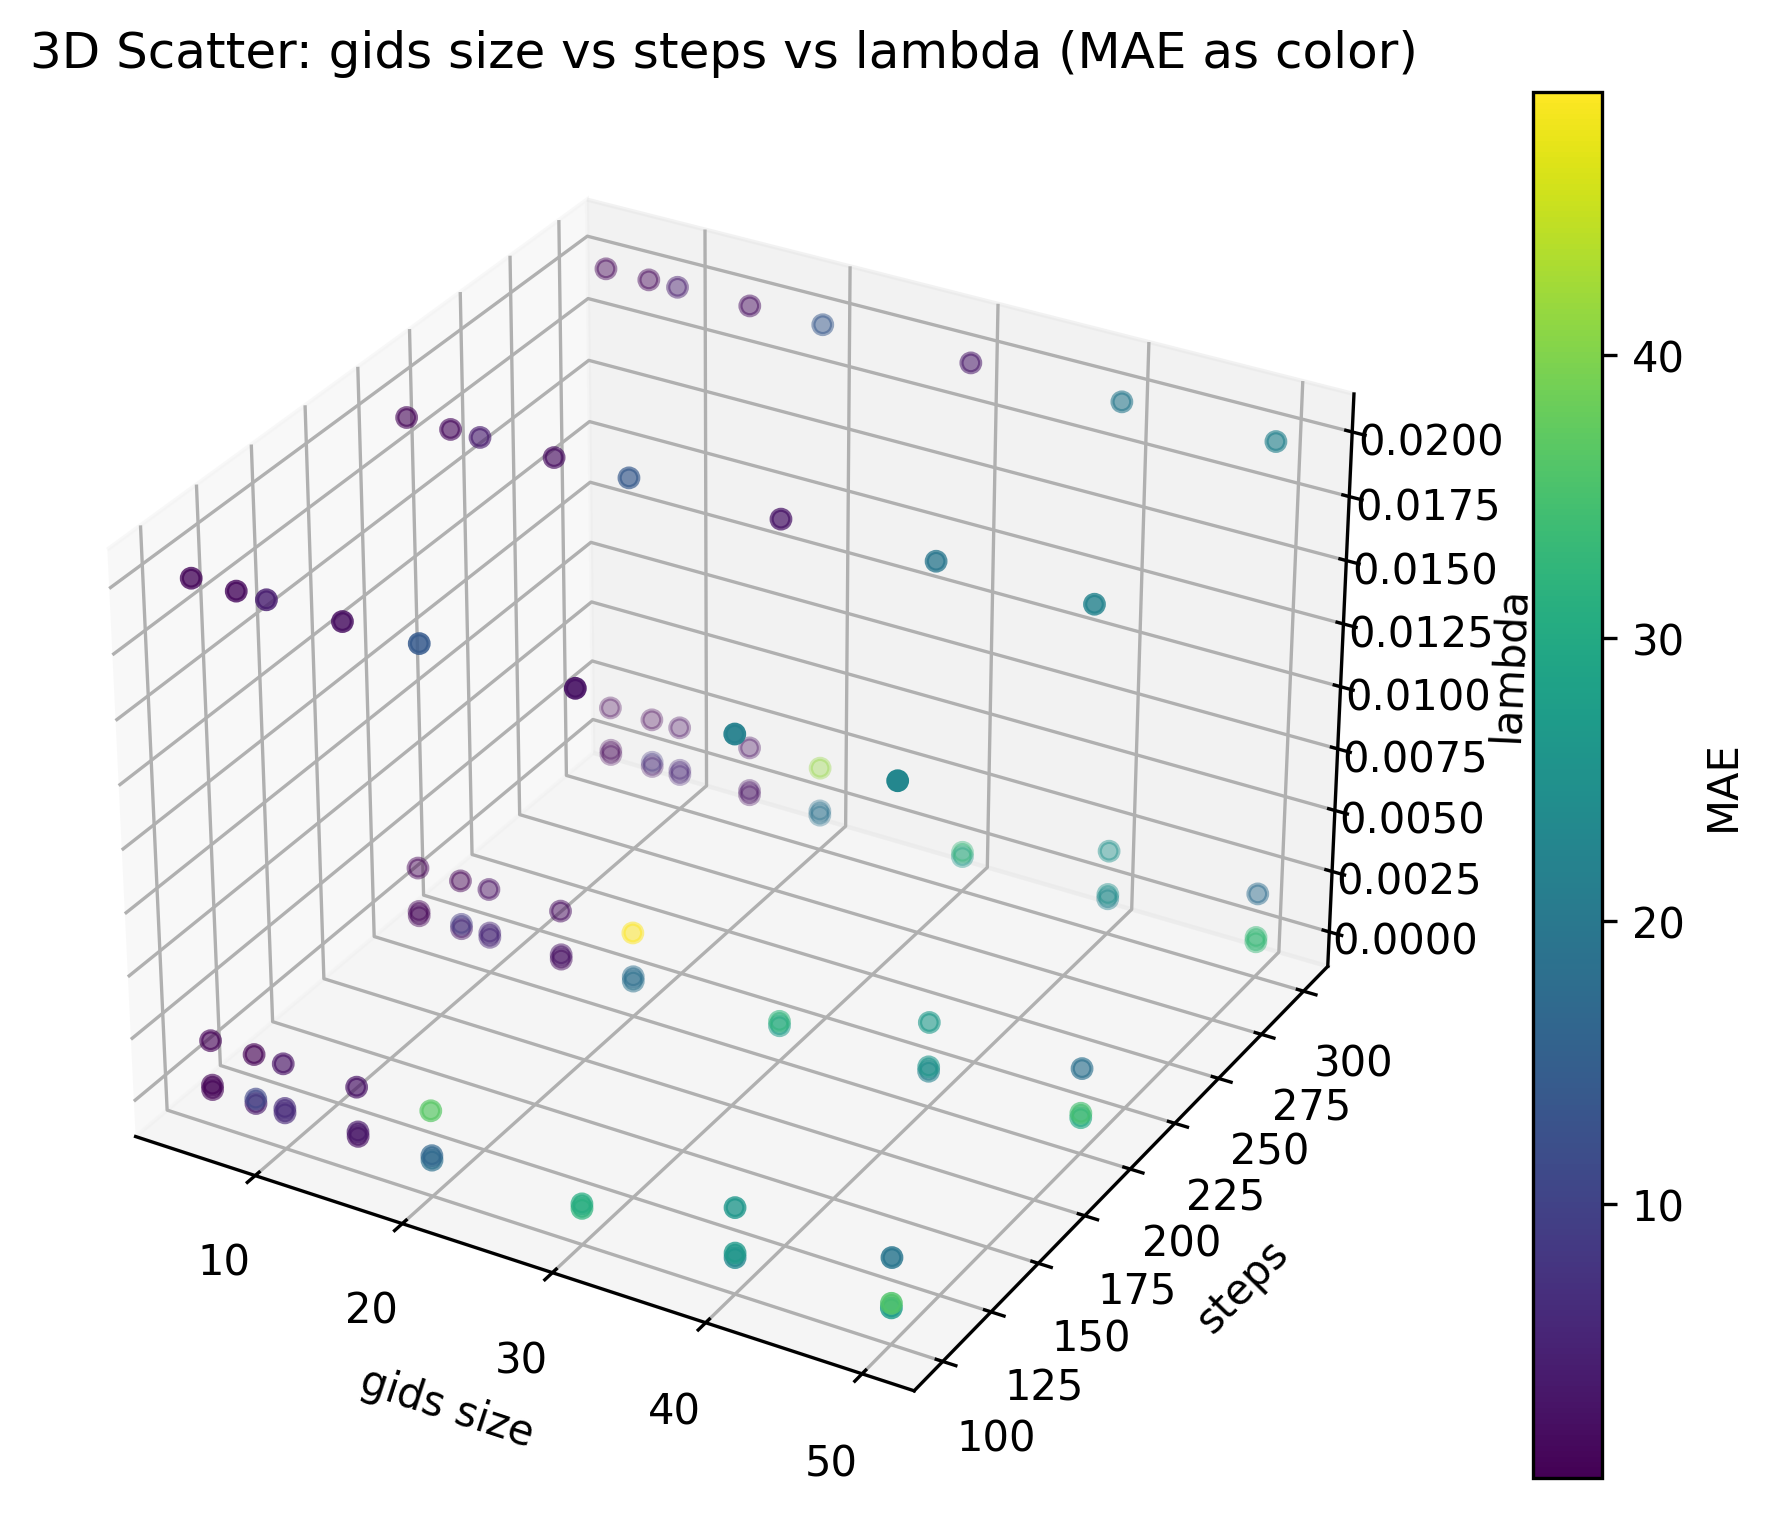

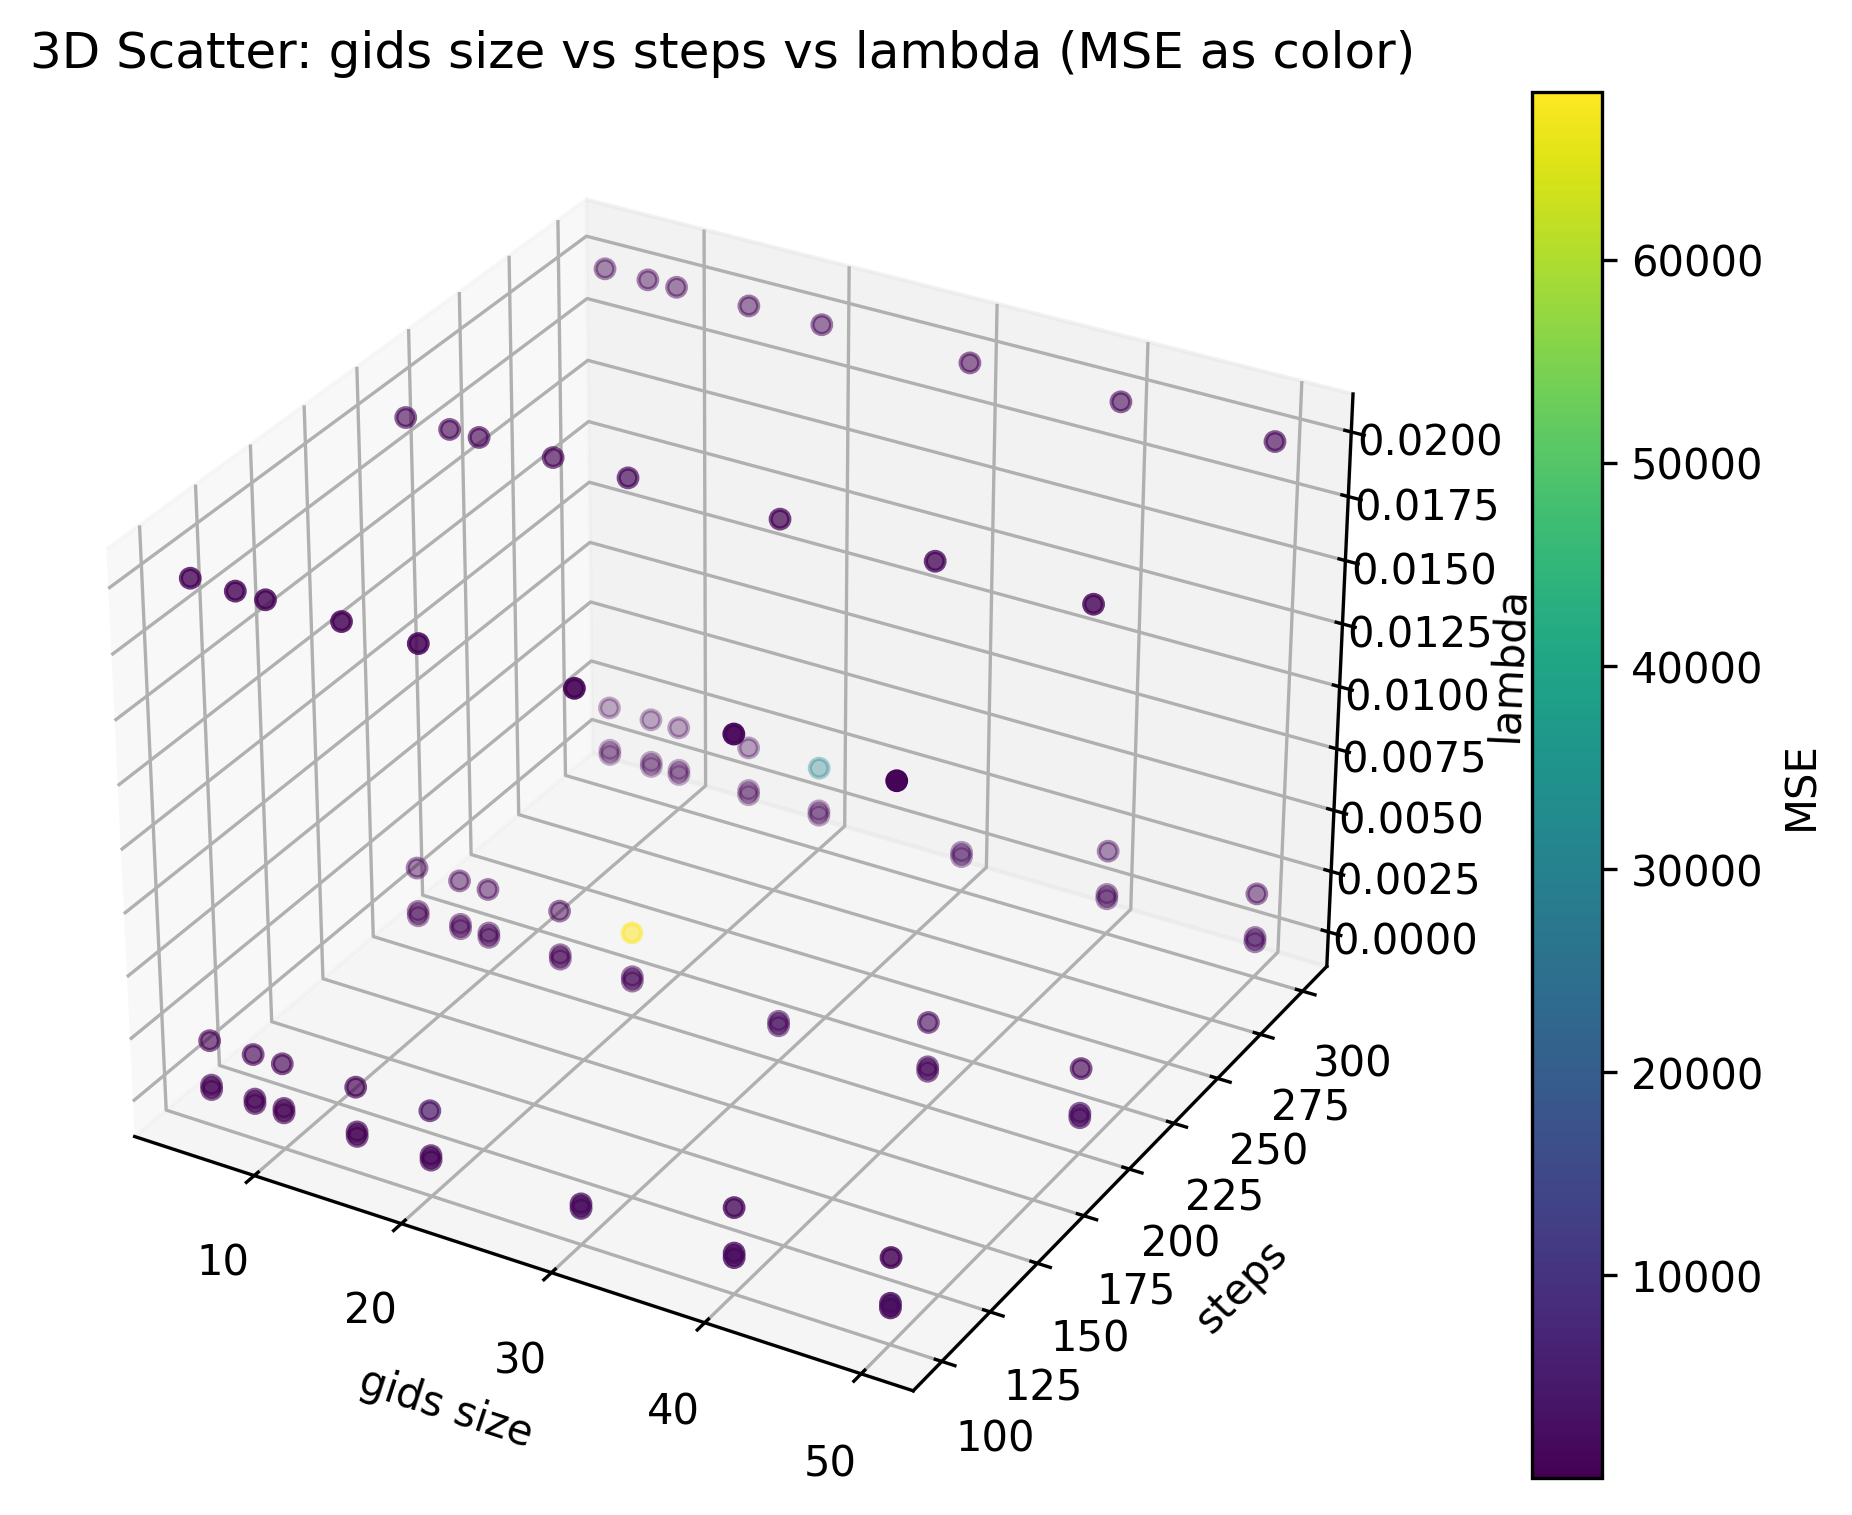

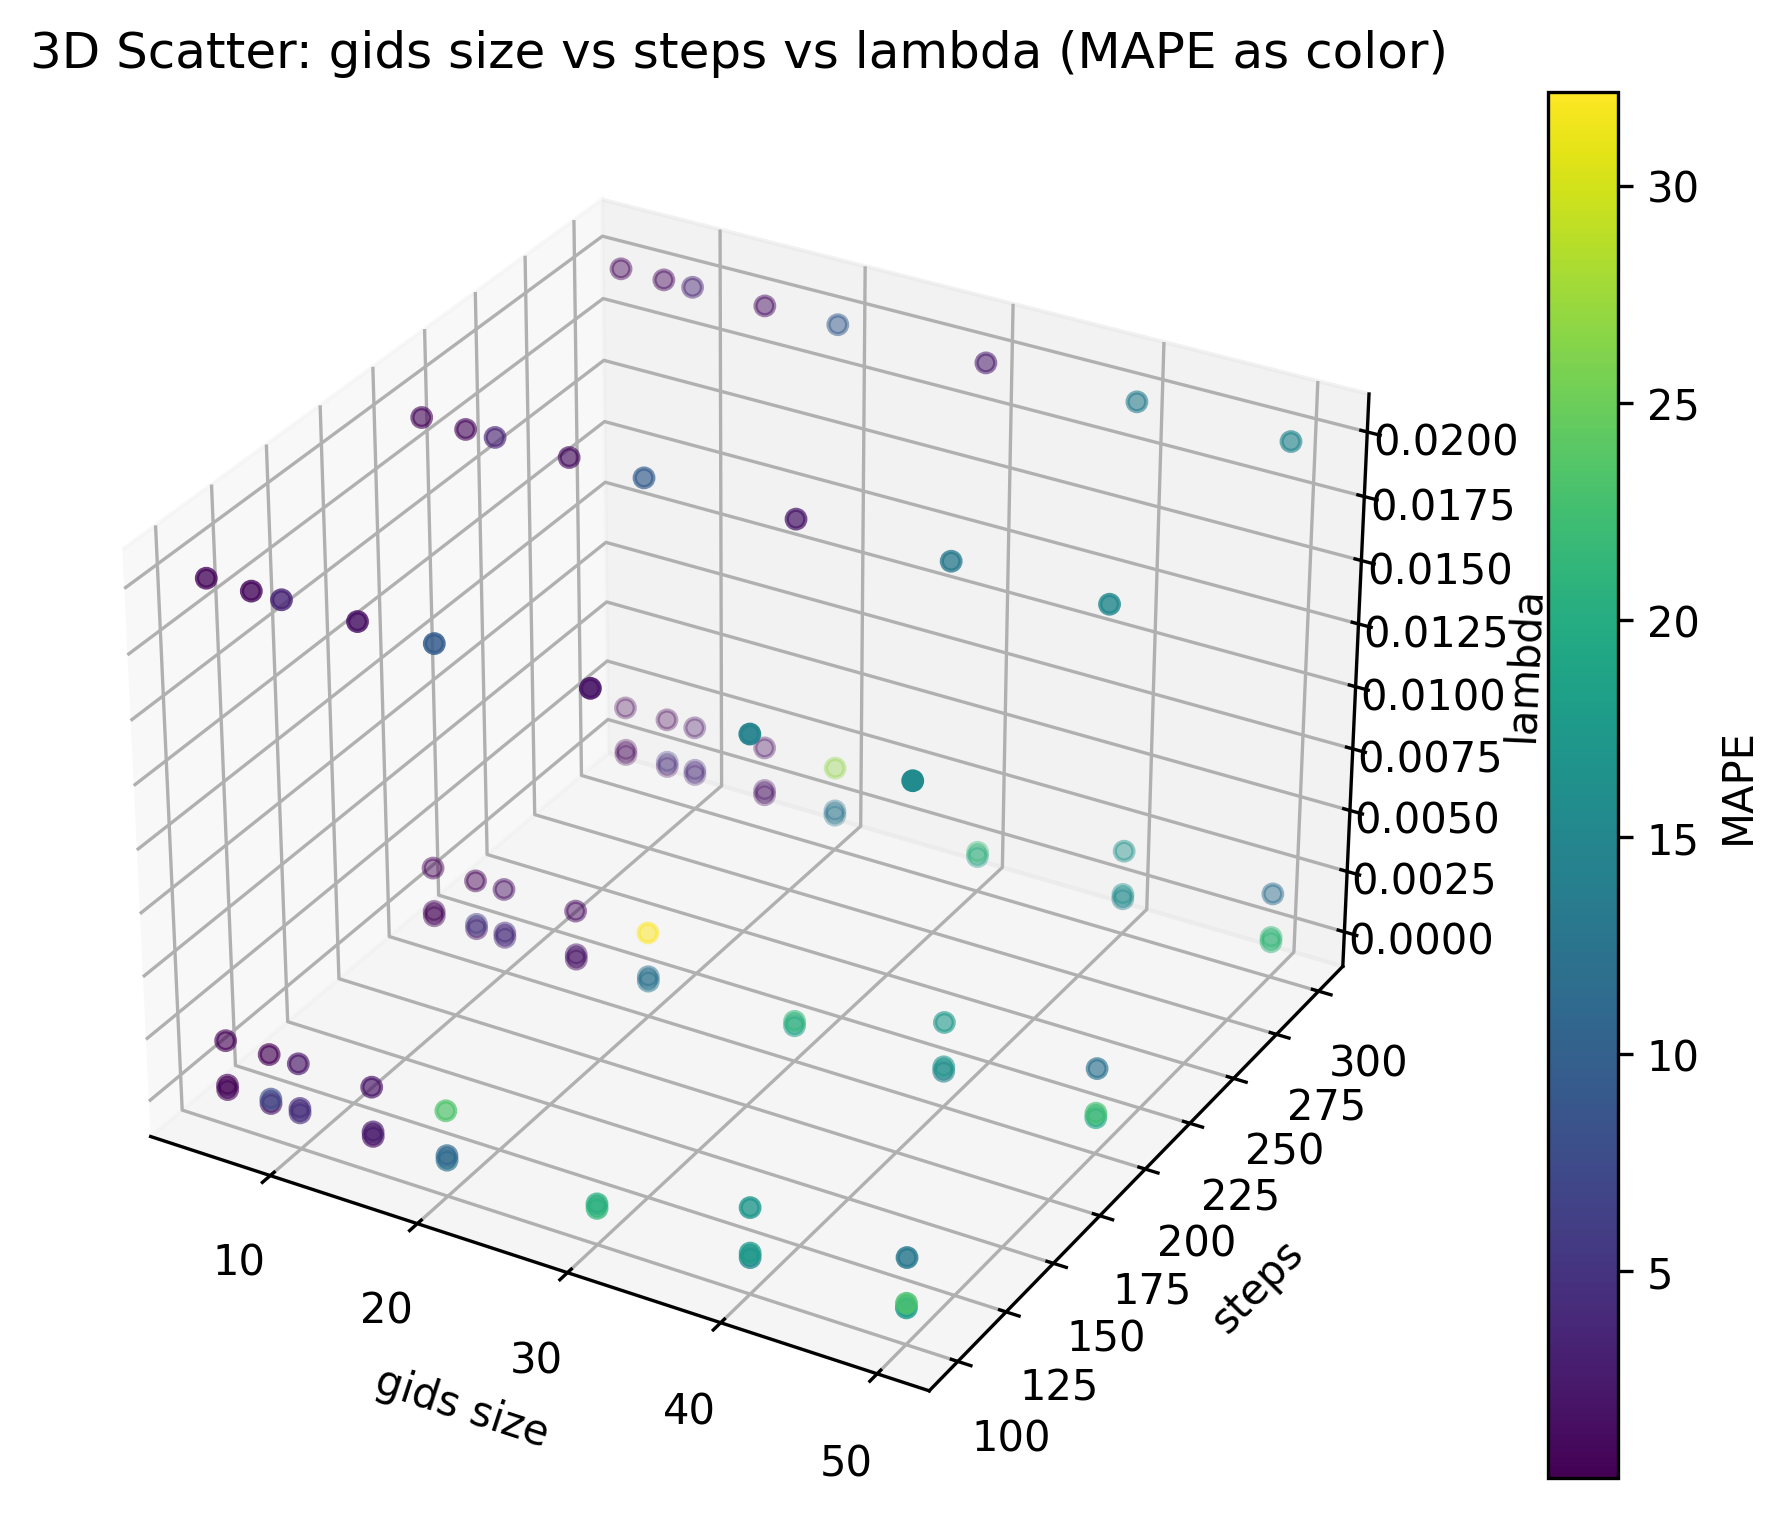

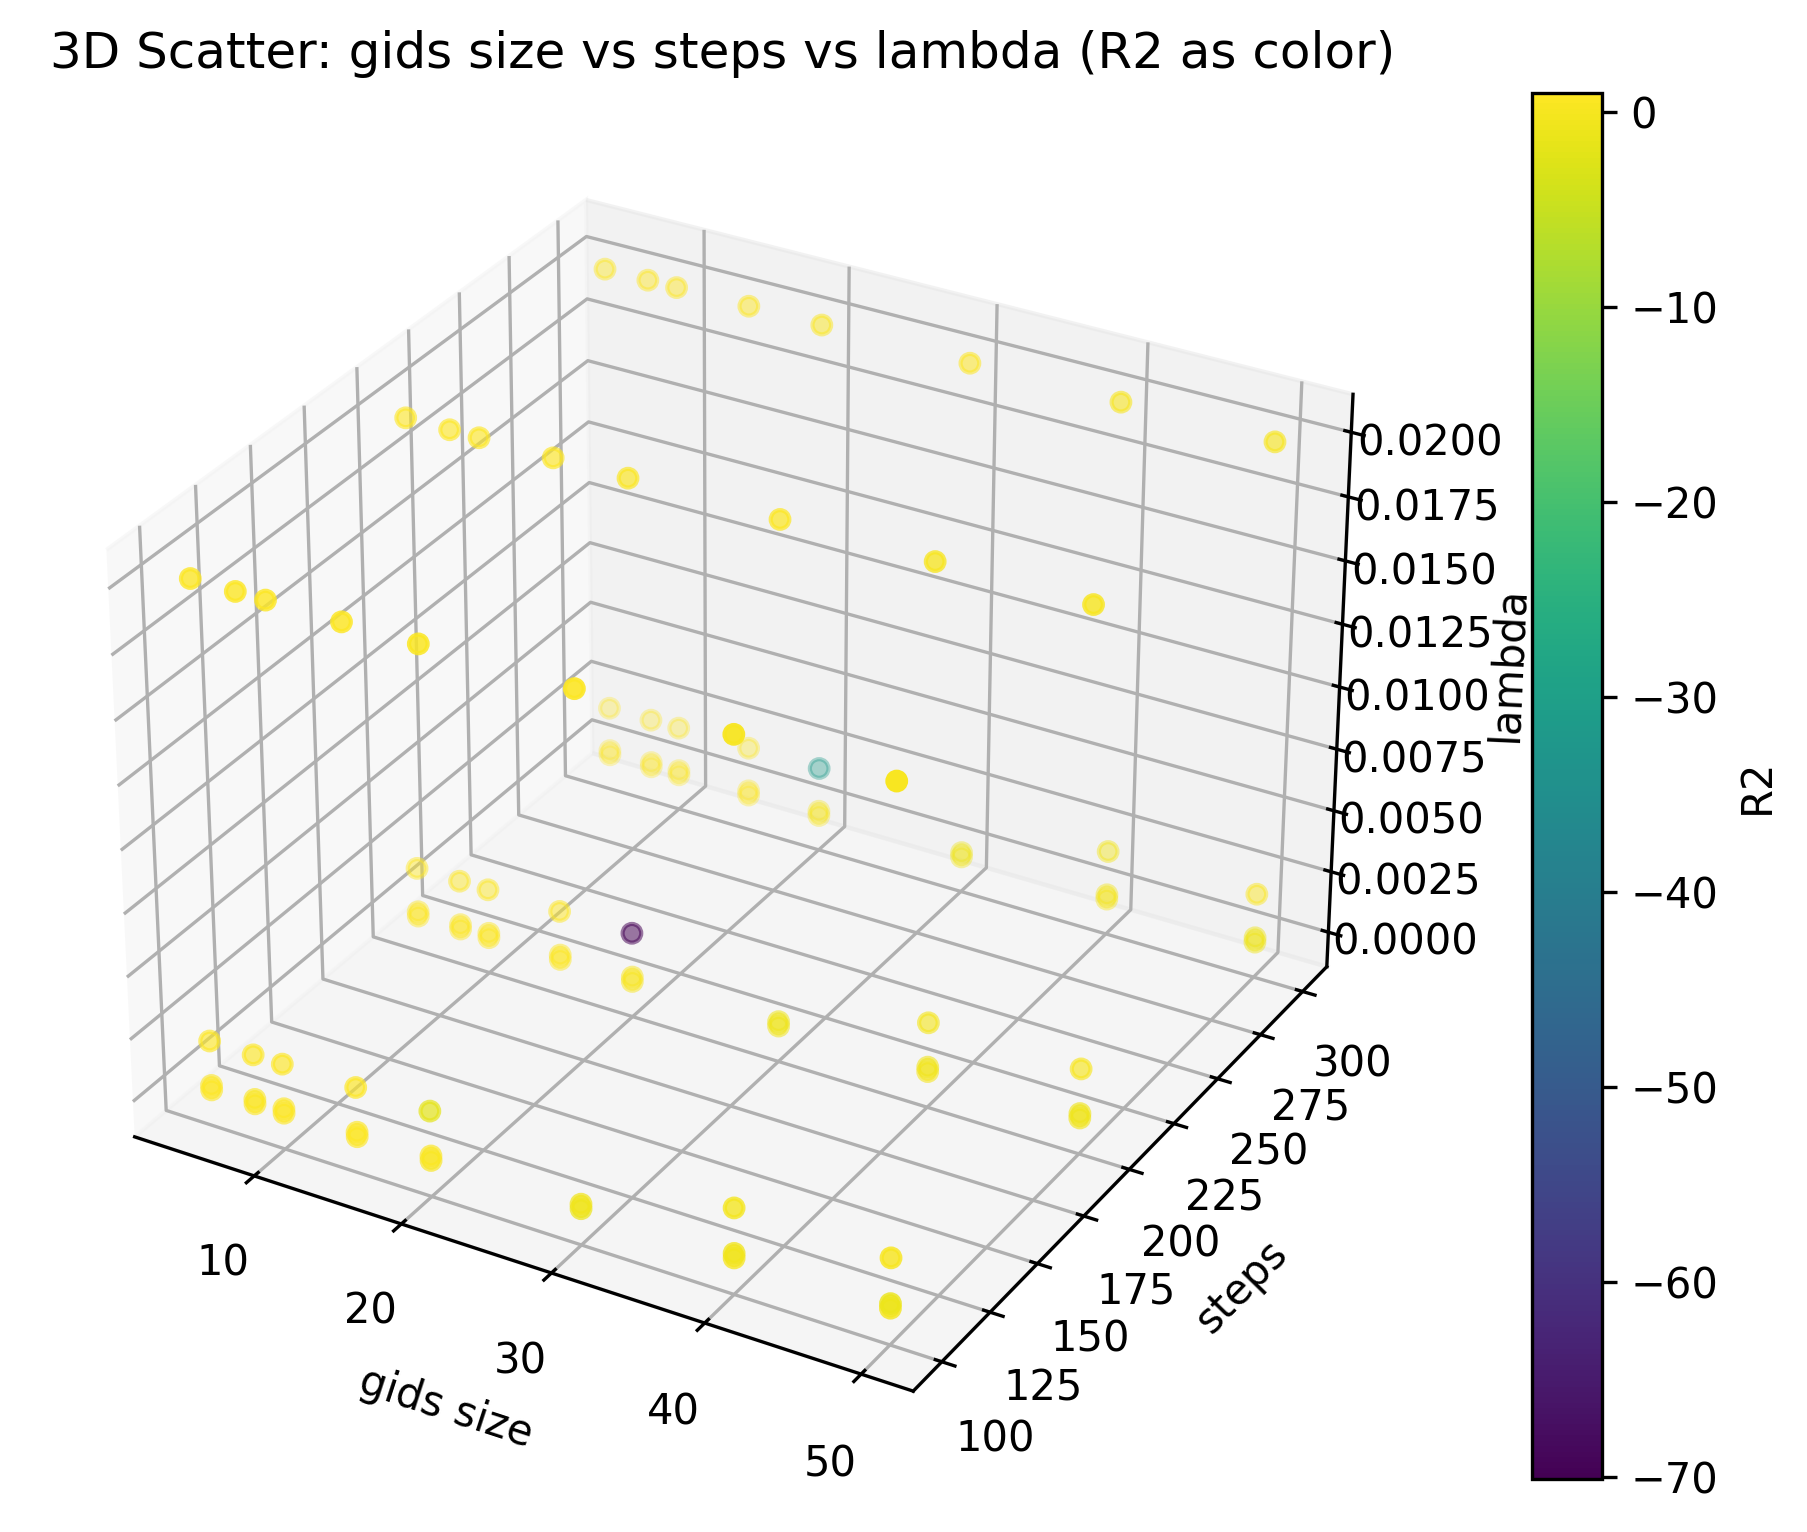

In [43]:
plot_gids_steps_lambda_loss(plot_grids, plot_steps, plot_lambs, tr_losses, "Train Loss")
plot_gids_steps_lambda_loss(plot_grids, plot_steps, plot_lambs, te_losses, 'Test Loss')
plot_gids_steps_lambda_loss(plot_grids, plot_steps, plot_lambs, tr_maes, 'MAE')
plot_gids_steps_lambda_loss(plot_grids, plot_steps, plot_lambs, tr_mses, 'MSE')
plot_gids_steps_lambda_loss(plot_grids, plot_steps, plot_lambs, tr_mapes, 'MAPE')
plot_gids_steps_lambda_loss(plot_grids, plot_steps, plot_lambs, tr_r2s, 'R2')

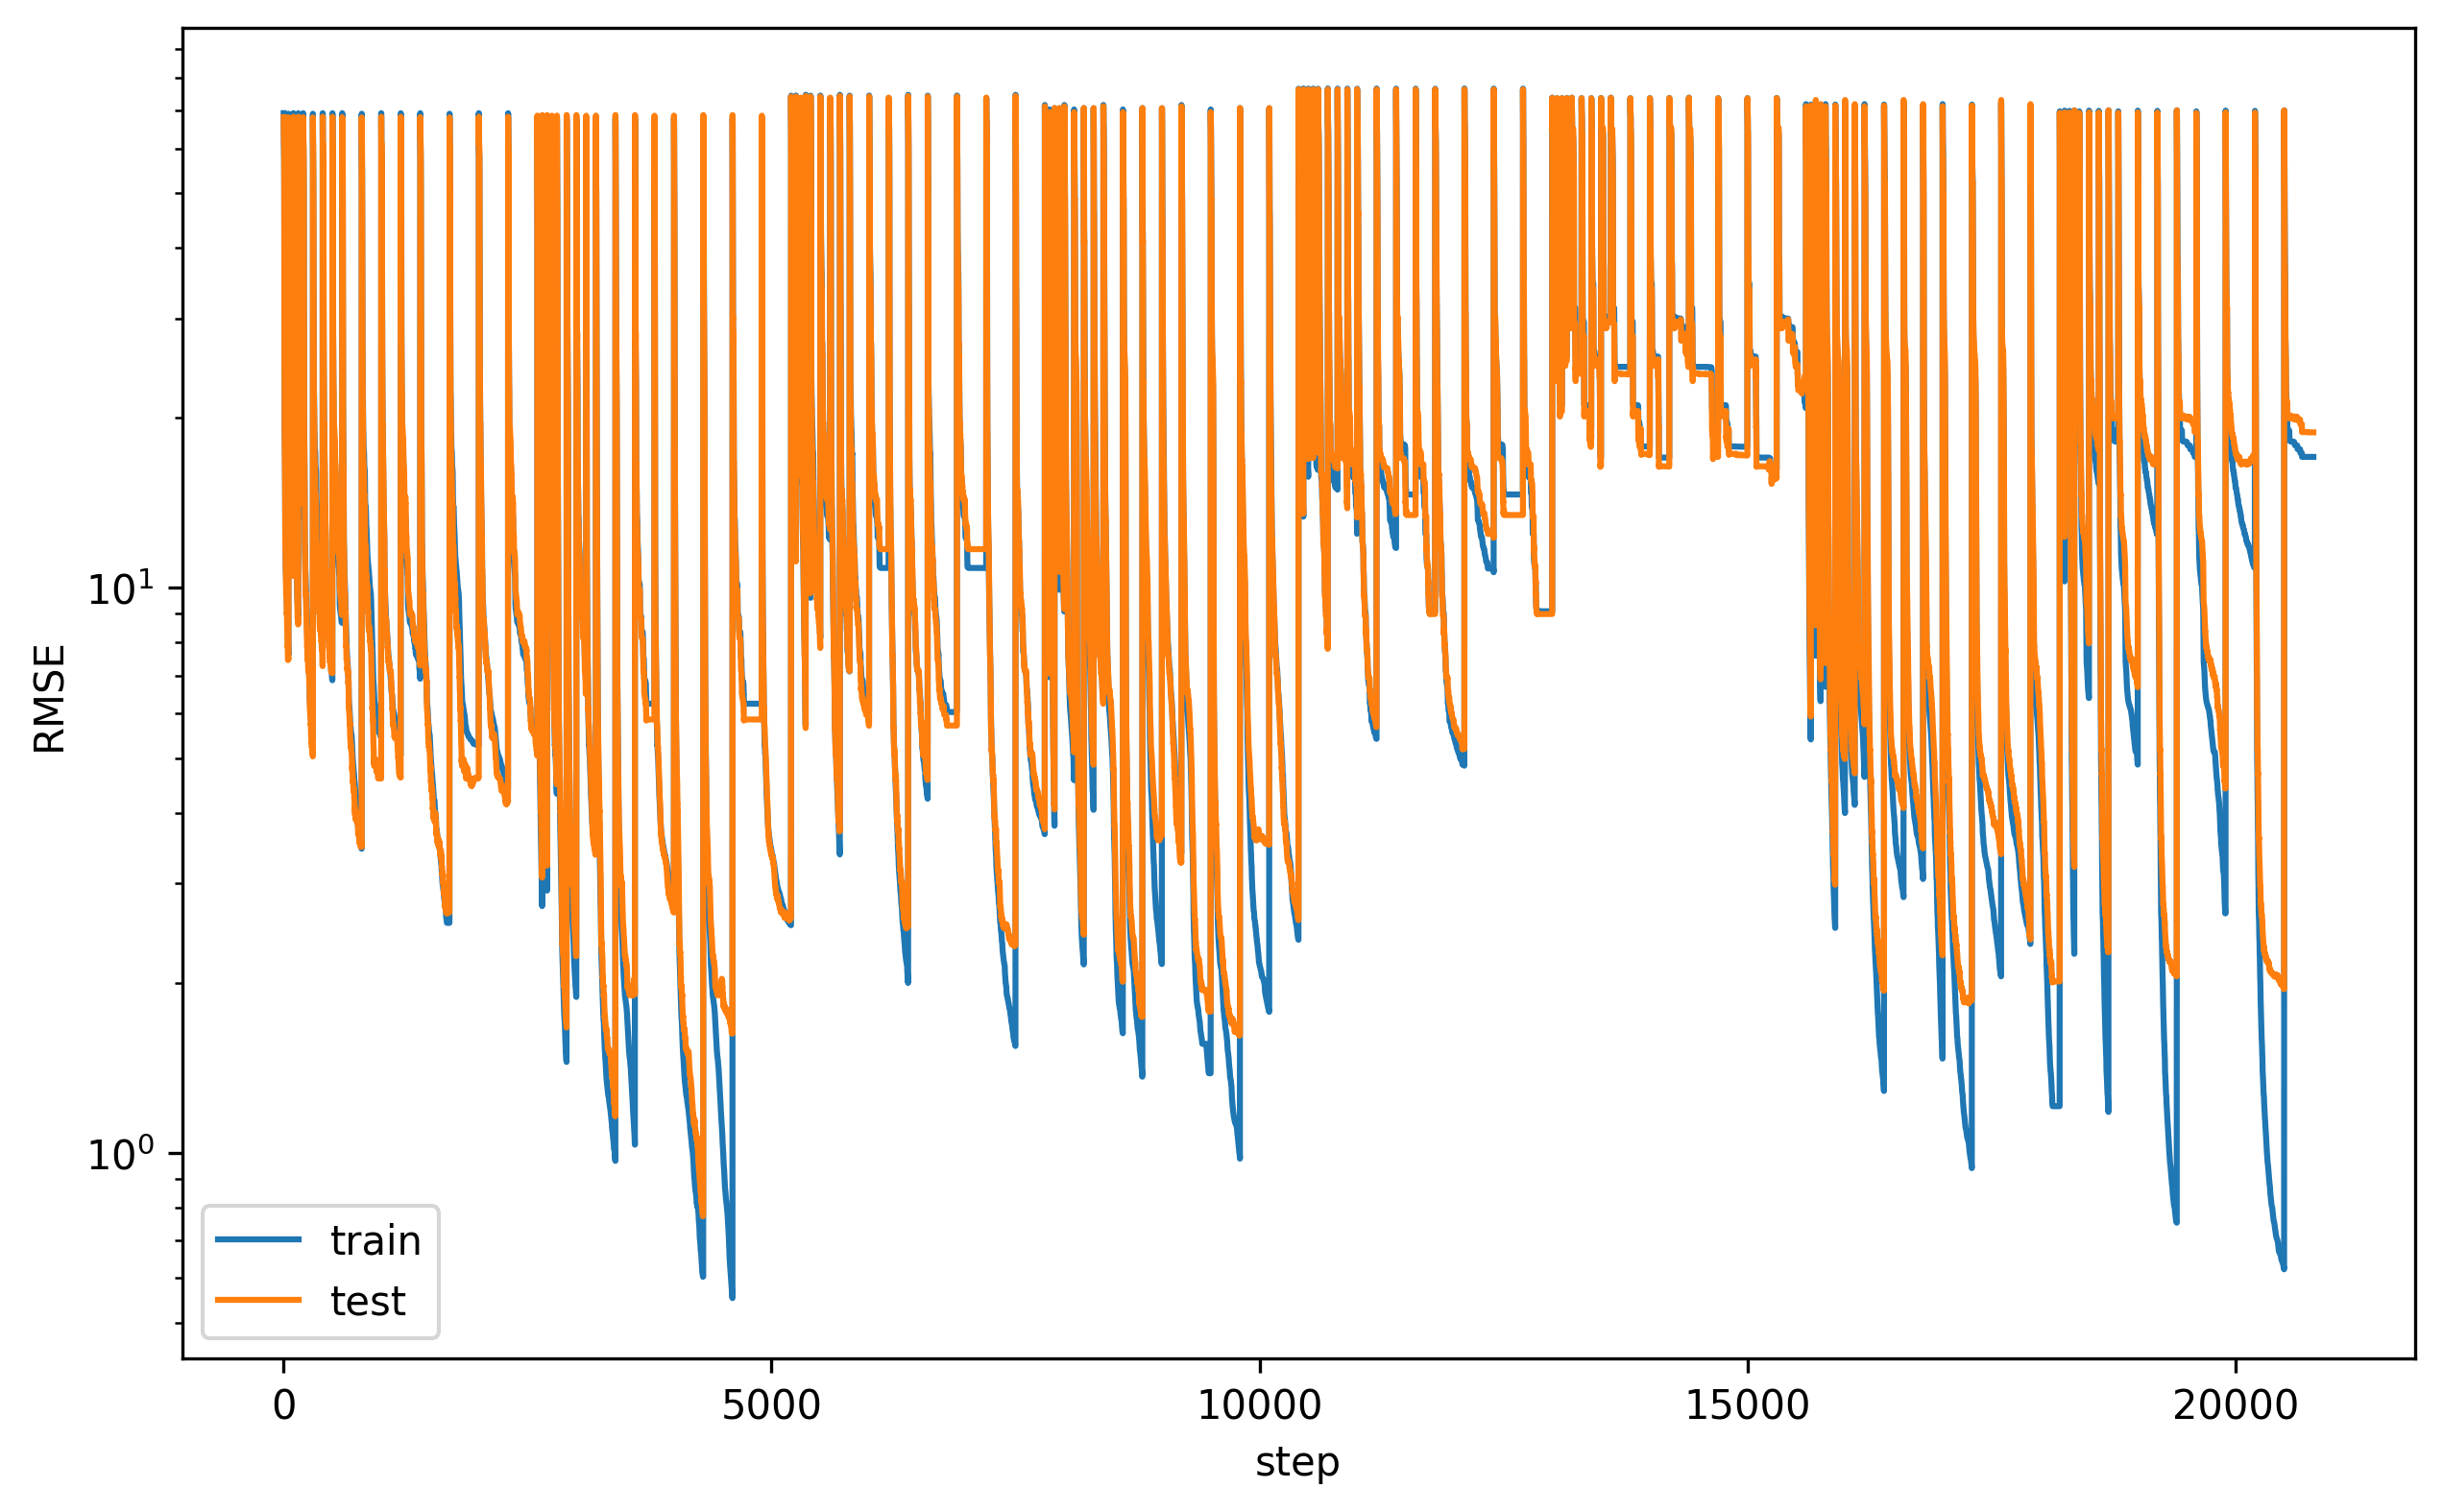

In [12]:
# Plot the training and test losses.
plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.45e+00 | test_loss: 1.67e+00 | reg: 1.33e+02 | : 100%|█| 100/100 [00:12<00:00,  7.98


saving model version 0.1
fixing (0,0,0) with exp, r2=0.9901150465011597, c=2
fixing (0,0,1) with x, r2=0.999987781047821, c=1
fixing (0,0,2) with x, r2=0.9965242743492126, c=1
fixing (0,0,3) with x, r2=0.968700110912323, c=1
fixing (0,1,0) with x, r2=0.9902373552322388, c=1
fixing (0,1,1) with x, r2=0.998756468296051, c=1
fixing (0,1,2) with x, r2=0.9934782385826111, c=1
fixing (0,1,3) with x, r2=0.9908829927444458, c=1
fixing (0,2,0) with x, r2=0.9662975072860718, c=1
fixing (0,2,1) with x, r2=1.0000003576278687, c=1
fixing (0,2,2) with x, r2=0.9935135245323181, c=1
fixing (0,2,3) with x, r2=1.000000238418579, c=1
fixing (0,3,0) with x, r2=0.773252546787262, c=1
fixing (0,3,1) with x, r2=0.9999545216560364, c=1
fixing (0,3,2) with x, r2=0.580936849117279, c=1
fixing (0,3,3) with x, r2=0.5879270434379578, c=1
fixing (1,0,0) with x, r2=0.996111273765564, c=1
fixing (1,1,0) with x, r2=0.4330796003341675, c=1
fixing (1,2,0) with x, r2=0.9789531230926514, c=1
fixing (1,3,0) with x, r2=0.05

| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 100/100 [00:18<00:00,  5.37it/s]


saving model version 0.3


ValueError: Input contains NaN.

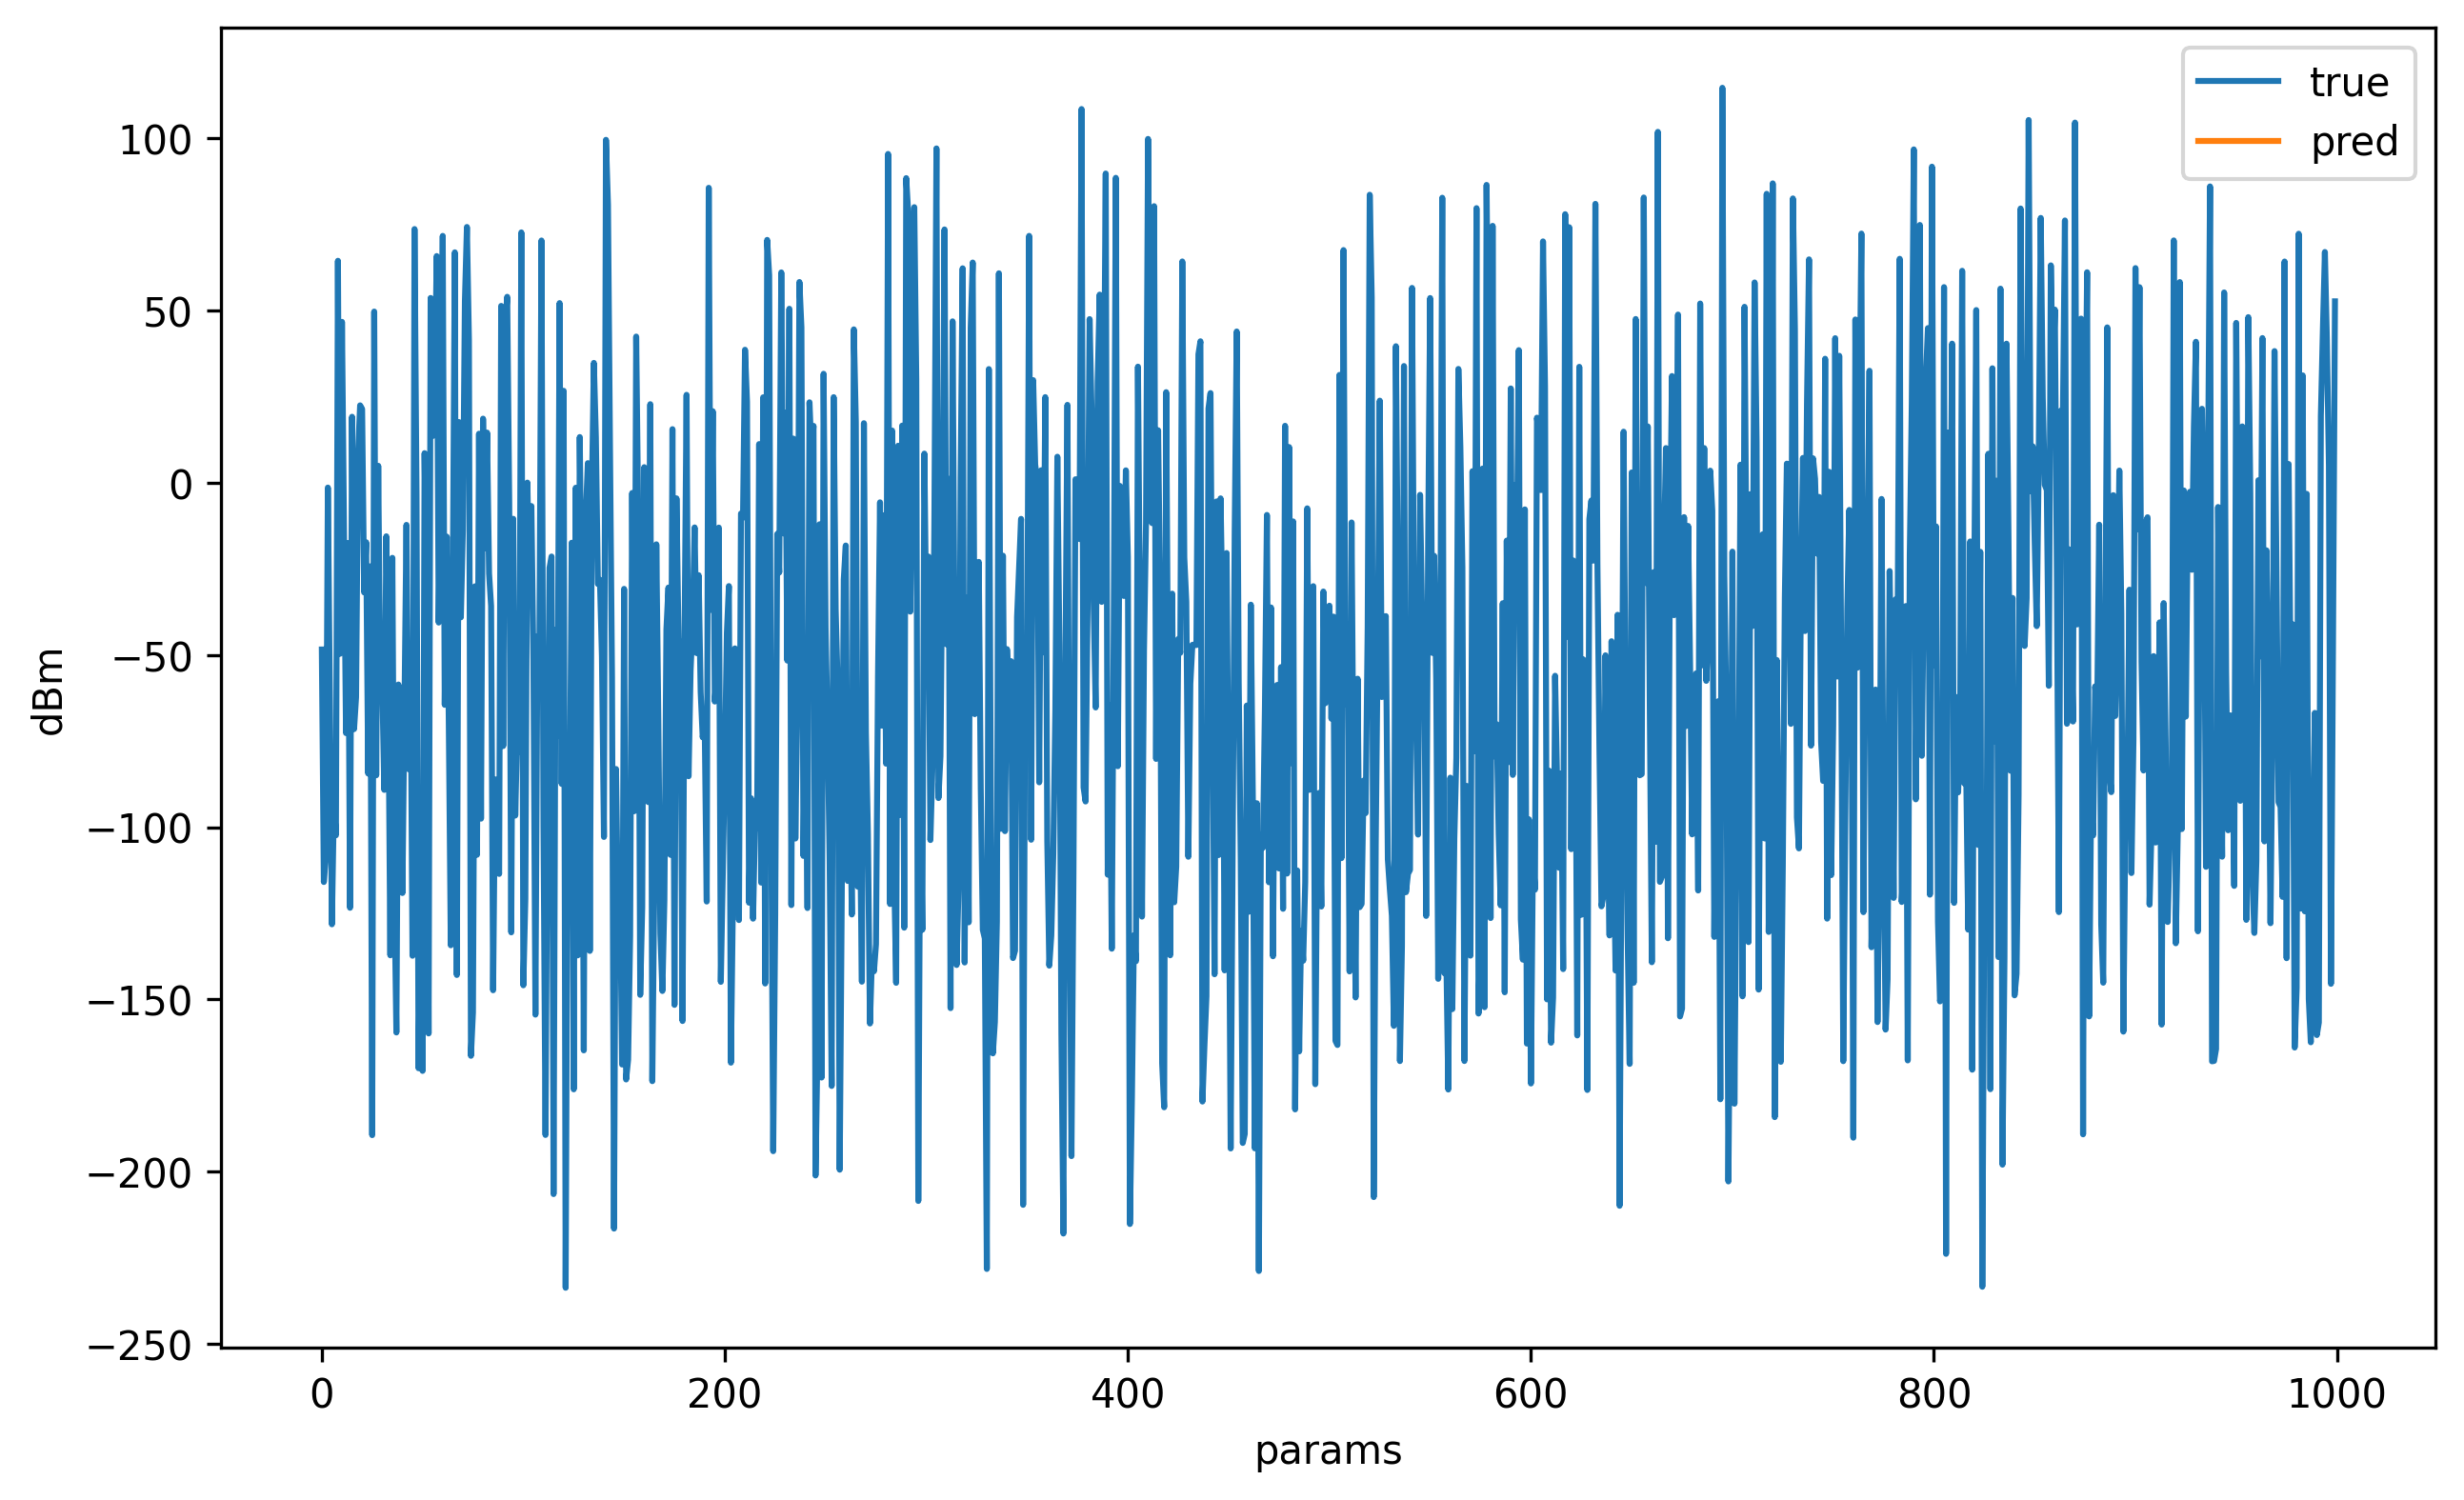

In [37]:
model = KAN(width=[4,4,1], grid=8, k=3, seed=42, device=device)

model.fit(dataset, opt="LBFGS", steps=100, lamb=0.02, lamb_entropy=2.);

lib = ['x', 'log', 'exp', 'sqrt', 'abs']
model.auto_symbolic(lib=lib)

# model.suggest_symbolic(0,0,0)
# model.suggest_symbolic(0,0,1)
# model.suggest_symbolic(0,0,2)
# model.suggest_symbolic(0,0,3) 
# model.suggest_symbolic(0,1,0) 
# model.suggest_symbolic(0,1,1) 

# model.fix_symbolic(0,0,0,'1/x^2')
# model.fix_symbolic(0,0,0,'x')
# model.fix_symbolic(0,0,0,'exp')
# model.fix_symbolic(0,0,0,'x')
# model.fix_symbolic(0,0,0,'sin')

# model.fix_symbolic(0,1,2,'x')
# model.fix_symbolic(0,1,3,'x') 
# model.fix_symbolic(0,2,0,'sqrt')
# model.fix_symbolic(0,2,1,'x') 
# model.fix_symbolic(0,2,2, 'log')
# model.fix_symbolic(0,2,3, 'x')

# model.suggest_symbolic(0,1,2)
# model.suggest_symbolic(0,1,3) 
# model.suggest_symbolic(0,2,0)
# model.suggest_symbolic(0,2,1) 
# model.suggest_symbolic(0,2,2)
# model.suggest_symbolic(0,2,3)
# #fixing (0,3,0) with 0, r2=0.0, c=0
# model.suggest_symbolic(0,3,1) 
# model.suggest_symbolic(0,3,2) 
# model.suggest_symbolic(0,3,3) 
# model.suggest_symbolic(1,0,0) 
# model.suggest_symbolic(1,1,0) 
# model.suggest_symbolic(1,2,0) 
# model.suggest_symbolic(1,3,0)

model.fit(dataset, opt="LBFGS", steps=100, lamb=0.02, lamb_entropy=2.);
eval_kan(model, dataset)



    function  fitting r2   r2 loss  complexity  complexity loss  total loss
0          x    0.997019 -8.384980           1                1   -0.876996
1      x^0.5    0.997166 -8.457640           2                2   -0.091528
2       sqrt    0.997166 -8.457640           2                2   -0.091528
3        log    0.997164 -8.456884           2                2   -0.091377
4  1/sqrt(x)    0.997164 -8.456673           2                2   -0.091335
  function  fitting r2   r2 loss  complexity  complexity loss  total loss
0        x    0.993790 -7.328863           1                1   -0.665773
1      cos    0.998800 -9.690469           2                2   -0.338094
2      sin    0.998800 -9.690469           2                2   -0.338094
3      x^2    0.997506 -8.641391           2                2   -0.128278
4      exp    0.997334 -8.545547           2                2   -0.109109
  function  fitting r2   r2 loss  complexity  complexity loss  total loss
0    x^0.5    0.998796 -9.

('x',
 (<function kan.utils.<lambda>(x)>,
  <function kan.utils.<lambda>(x)>,
  1,
  <function kan.utils.<lambda>(x, y_th)>),
 np.float64(1.000000238418579),
 np.int64(1))

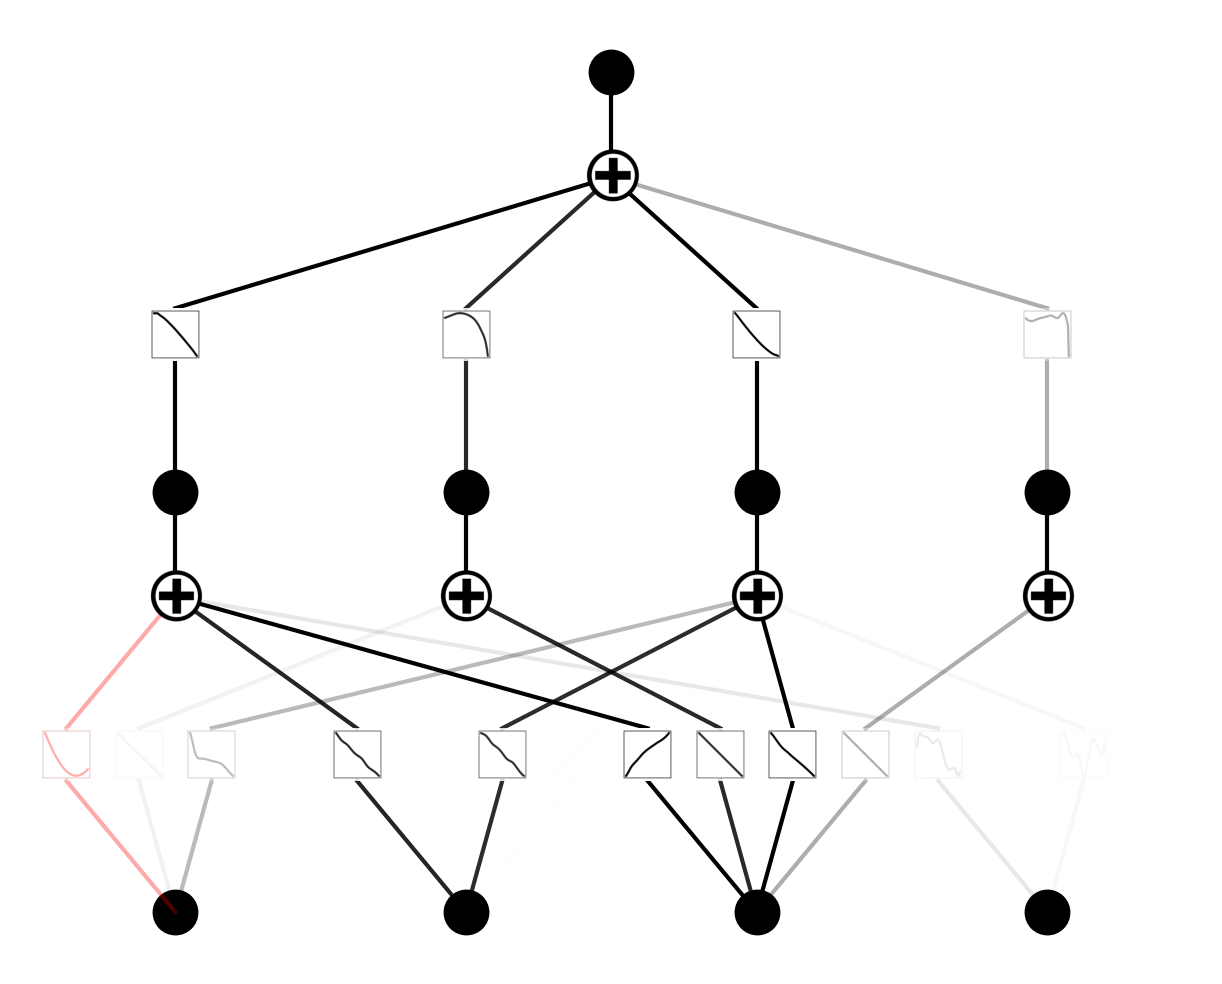

In [33]:
model.plot()

model.suggest_symbolic(0,1,2)
model.suggest_symbolic(0,1,3) 
model.suggest_symbolic(0,2,0)
model.suggest_symbolic(0,2,1) 
model.suggest_symbolic(0,2,2)
model.suggest_symbolic(0,2,3)



r2 is 0.9970186352729797
saving model version 0.8
r2 is 0.9937899708747864
saving model version 0.9
r2 is 0.9987955093383789
saving model version 0.10
r2 is 1.000000238418579
saving model version 0.11
r2 is 0.997937798500061
saving model version 0.12
r2 is 1.000000238418579
saving model version 0.13


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 100/100 [00:18<00:00,  5.36it/s]


saving model version 0.14


ValueError: Input contains NaN.

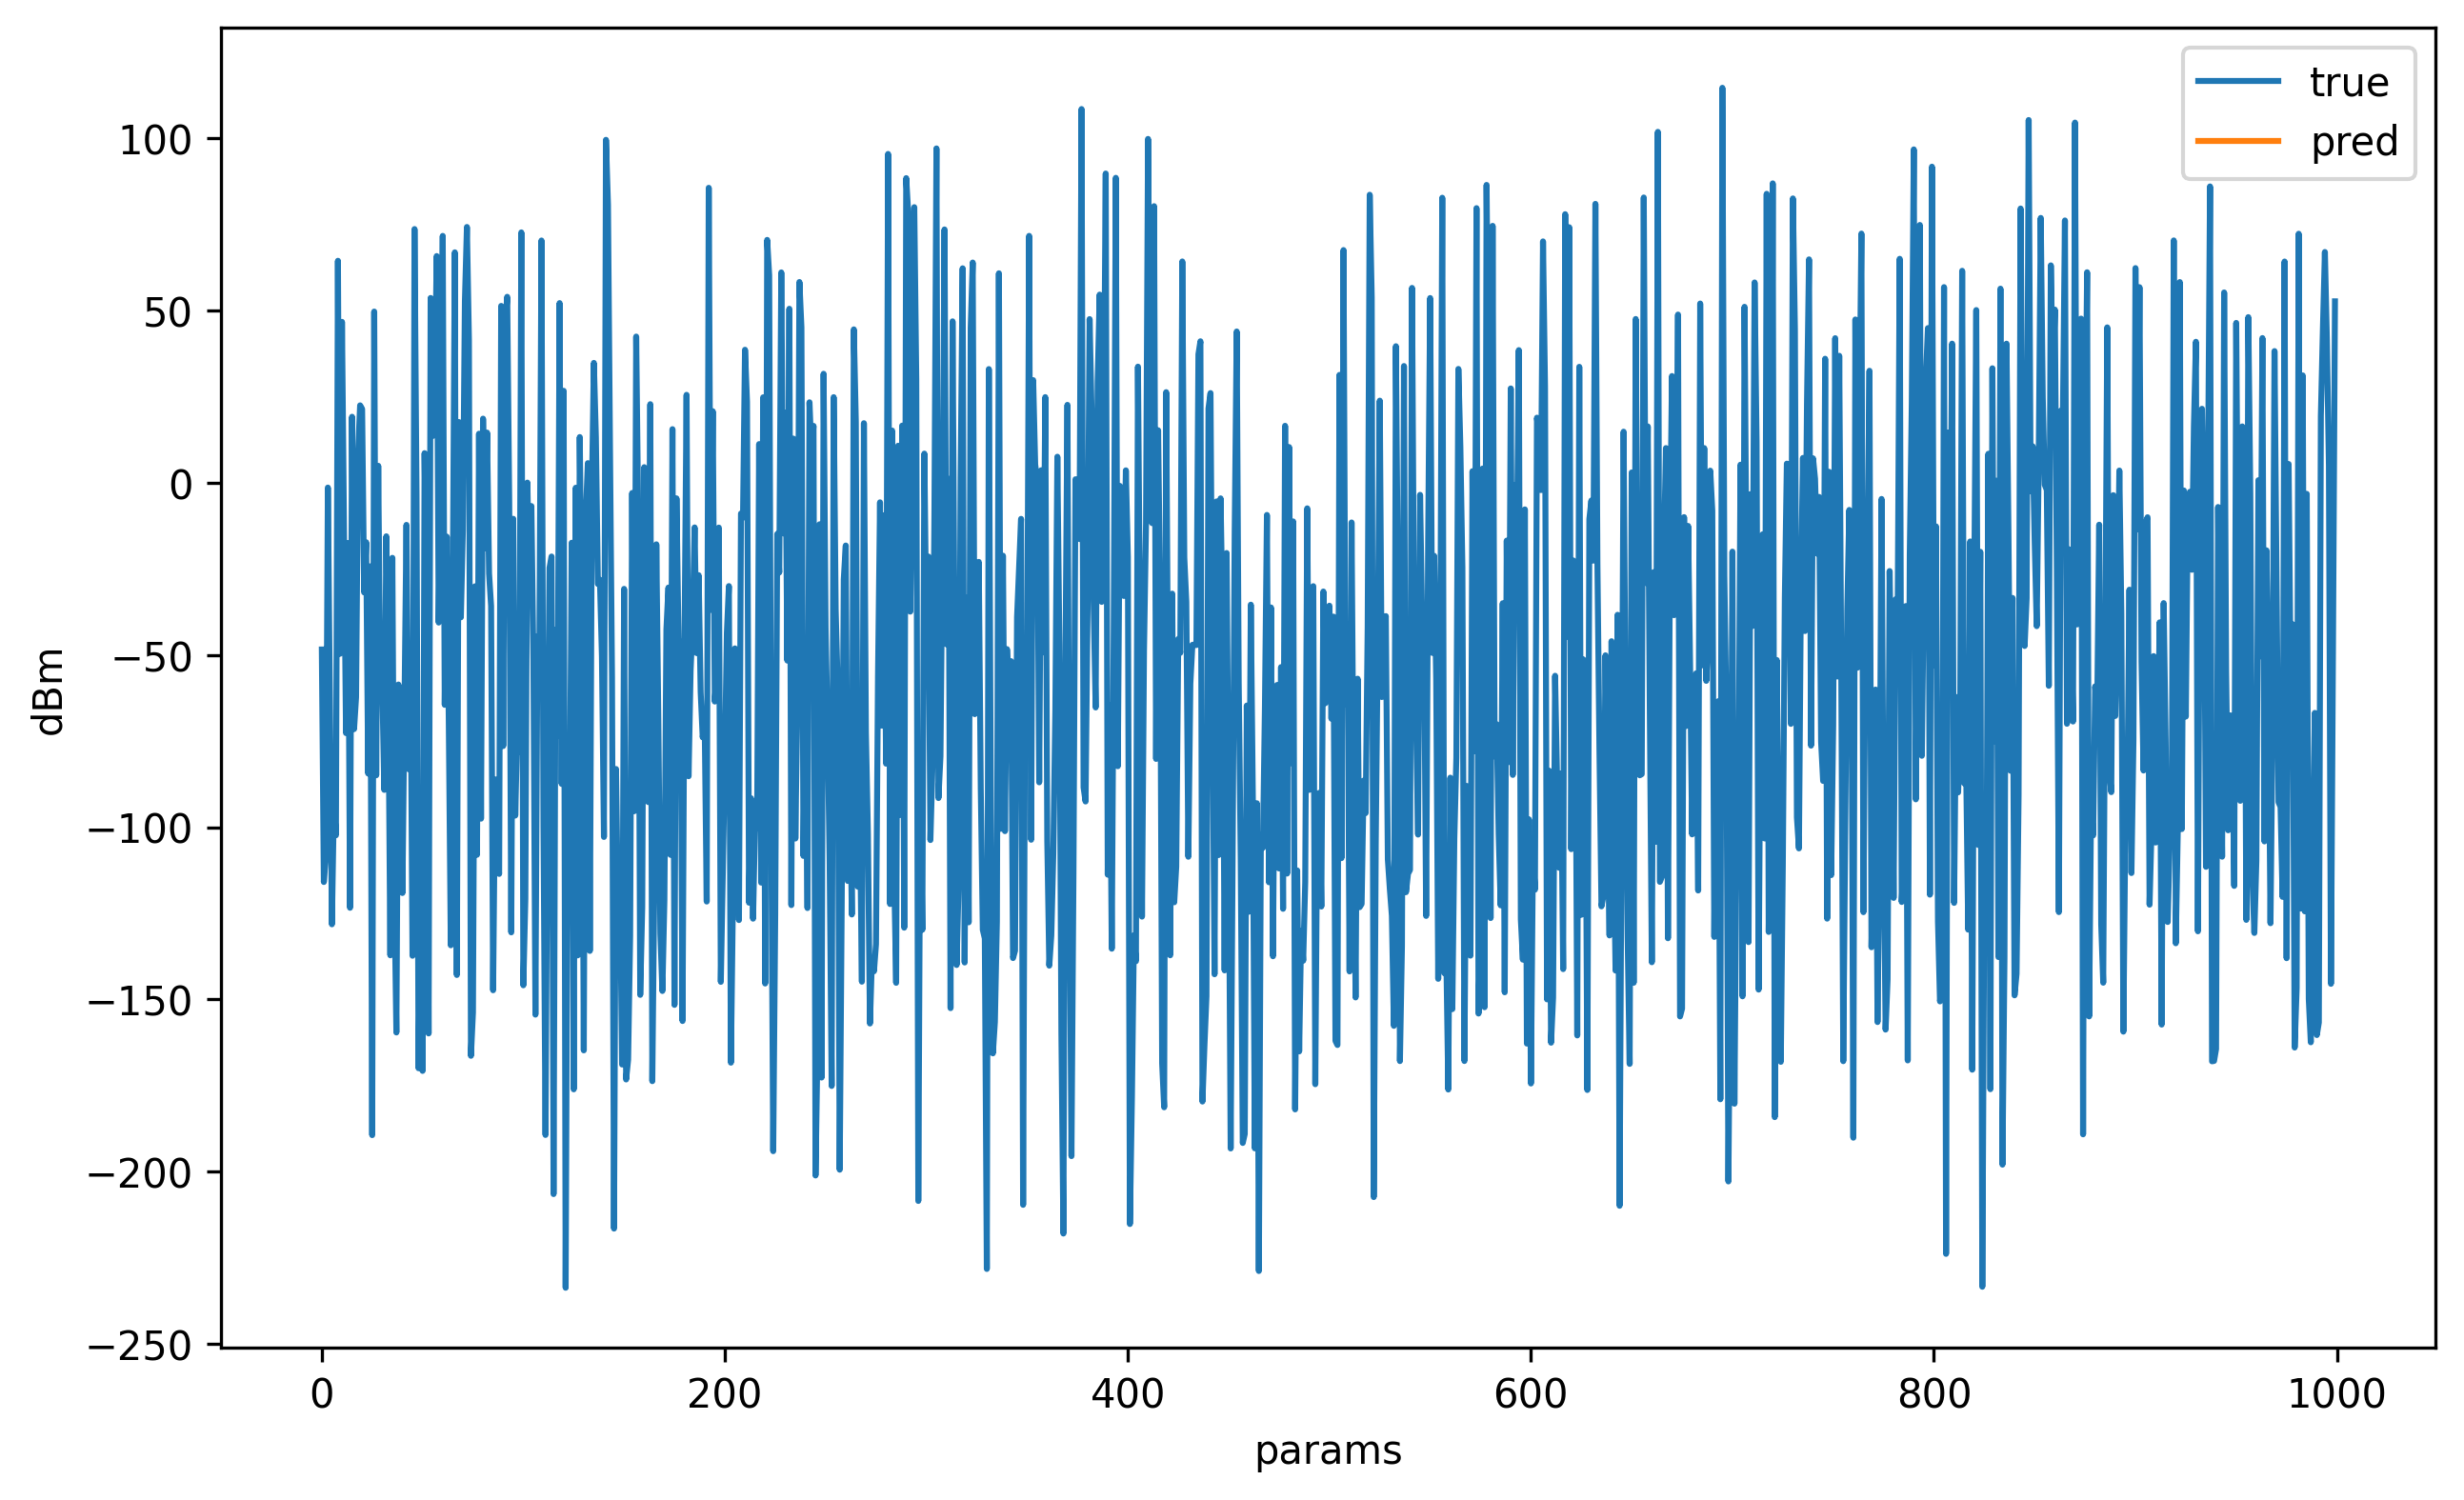

In [35]:
model.fix_symbolic(0,1,2,'x')
model.fix_symbolic(0,1,3,'x') 
model.fix_symbolic(0,2,0,'sqrt')
model.fix_symbolic(0,2,1,'x') 
model.fix_symbolic(0,2,2, 'log')
model.fix_symbolic(0,2,3, 'x')

model.fit(dataset, opt="LBFGS", steps=100, lamb=0.02, lamb_entropy=2.);
eval_kan(model, dataset)

model.plot()

formula = model.symbolic_formula()[0][0]
nsimplify(ex_round(formula, 4))